In [3]:
import os
from dataclasses import dataclass, field
from pathlib import Path
from typing import Union, Optional

import draccus
from accelerate.utils import set_seed

from vlm_eval.conf import DatasetConfig, DatasetRegistry
from vlm_eval.models import load_vlm
from vlm_eval.overwatch import initialize_overwatch
from vlm_eval.tasks import get_task_runner
from torch.utils.data import DataLoader, Dataset, DistributedSampler
import torch
from prismatic.models import get_llm_backbone_and_tokenizer, get_vision_backbone_and_transform, get_vlm
from prismatic.overwatch import initialize_overwatch
from prismatic.preprocessing import get_dataset_and_collator
from prismatic.conf import DatasetConfig, DatasetRegistry, ModelConfig, ModelRegistry
from prismatic.util.batching_utils import SplitModalitySampler

def get_embeddings(vlm):
    tokenizer, image_transform = vlm.model.llm_backbone.tokenizer, vlm.model.vision_backbone.image_transform
    dataset_cfg: DatasetConfig = DatasetConfig.get_choice_class('llava-v15')
    train_dataset, collator = get_dataset_and_collator(
            'finetune',
            dataset_cfg,
            image_transform,
            tokenizer,
            prompt_builder_fn=vlm.model.llm_backbone.prompt_builder_fn,
            default_image_resolution=vlm.model.vision_backbone.default_image_resolution,
            padding_side=tokenizer.padding_side,
        )


    modality_lengths = train_dataset.get_modality_lengths()
    sampler = SplitModalitySampler(
            train_dataset,
            modality_lengths,
            global_batch_size=1,
            num_replicas=1,
            rank=0,
            seed=123,
            drop_last=False,
        )
        
    dataloader = DataLoader(
            train_dataset,
            batch_size=8,
            sampler=sampler,
            collate_fn=collator,
            num_workers=12,
            worker_init_fn=None,
        )
    for idx, batch in enumerate(dataloader):
        #pixel_values, input_ids, attention_mask, labels = batch['pixel_values'], batch['input_ids'], batch['attention_mask'], batch['labels']
        break
        
    vlm.model.train()
    with torch.autocast("cuda", dtype=torch.bfloat16):
        batch = {k: v.to("cuda") if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        input_ids, attention_mask, pixel_values, labels, multimodal_indices = batch["input_ids"], batch["attention_mask"], batch["pixel_values"], batch["labels"], batch["multimodal_indices"]

        with torch.set_grad_enabled(False):
            if isinstance(pixel_values, dict):
                patch_features = vlm.model.vision_backbone({k: pixel_values[k][multimodal_indices] for k in pixel_values})
            else:
                patch_features = vlm.model.vision_backbone(pixel_values[multimodal_indices])

        # Projection Logic :: [bsz, num_patches, llm_embed_dim] =>> num_patches = (2 *) (256 + 1) for ViT-L + CLS
        projector = vlm.model.projector
        projected_patch_embeddings = projector(patch_features)
        projected_patch_attention_mask = None
        if attention_mask is not None:
            projected_patch_attention_mask = torch.full(
                (projected_patch_embeddings.shape[0], projected_patch_embeddings.shape[1]),
                True,
                dtype=attention_mask.dtype,
                device=attention_mask.device,
            )

        # Get Input Embeddings from LLM Backbone :: [bsz, input_seq_len, llm_embed_dim]
        llm_backbone = vlm.model.llm_backbone
        input_embeddings = llm_backbone.embed_input_ids(input_ids)

    print(tokenizer.decode(input_ids[0], skip_special_tokens=True))
    plot_image(pixel_values[0])
    print(tokenizer.decode(input_ids[1], skip_special_tokens=True))
    plot_image(pixel_values[1])
    print(tokenizer.decode(input_ids[2], skip_special_tokens=True))
    plot_image(pixel_values[2])
    print(tokenizer.decode(input_ids[3], skip_special_tokens=True))
    plot_image(pixel_values[3])
    print(tokenizer.decode(input_ids[4], skip_special_tokens=True))
    plot_image(pixel_values[4])
    print(tokenizer.decode(input_ids[5], skip_special_tokens=True))
    plot_image(pixel_values[5])
    print(tokenizer.decode(input_ids[6], skip_special_tokens=False))
    plot_image(pixel_values[6])

    return projected_patch_embeddings, input_embeddings, patch_features, input_ids, projected_patch_attention_mask, attention_mask
    
def get_embeddings_baseline(vlm):
    tokenizer, image_transform = vlm.model.llm_backbone.tokenizer, vlm.model.vision_backbone.image_transform
    dataset_cfg: DatasetConfig = DatasetConfig.get_choice_class('gqa-only')
    train_dataset, collator = get_dataset_and_collator(
            'finetune',
            dataset_cfg,
            image_transform,
            tokenizer,
            prompt_builder_fn=vlm.model.llm_backbone.prompt_builder_fn,
            default_image_resolution=vlm.model.vision_backbone.default_image_resolution,
            padding_side=tokenizer.padding_side,
        )


    modality_lengths = train_dataset.get_modality_lengths()
    sampler = SplitModalitySampler(
            train_dataset,
            modality_lengths,
            global_batch_size=1,
            num_replicas=1,
            rank=0,
            seed=256,
            drop_last=False,
        )
        
    dataloader = DataLoader(
            train_dataset,
            batch_size=8,
            sampler=sampler,
            collate_fn=collator,
            num_workers=12,
            worker_init_fn=None,
        )
    for idx, batch in enumerate(dataloader):
        if idx >= 2:
            break
        
    vlm.model.train()
    with torch.autocast("cuda", dtype=torch.bfloat16):
        batch = {k: v.to("cuda") if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        input_ids, attention_mask, pixel_values, labels, multimodal_indices = batch["input_ids"], batch["attention_mask"], batch["pixel_values"], batch["labels"], batch["multimodal_indices"]

        with torch.set_grad_enabled(False):
            if isinstance(pixel_values, dict):
                patch_features = vlm.model.vision_backbone({k: pixel_values[k][multimodal_indices] for k in pixel_values})
            else:
                patch_features = vlm.model.vision_backbone(pixel_values[multimodal_indices])

        # Projection Logic :: [bsz, num_patches, llm_embed_dim] =>> num_patches = (2 *) (256 + 1) for ViT-L + CLS
        projector = vlm.model.projector
        projected_patch_embeddings = projector(patch_features)
        projected_patch_attention_mask = None
        if attention_mask is not None:
            projected_patch_attention_mask = torch.full(
                (projected_patch_embeddings.shape[0], projected_patch_embeddings.shape[1]),
                True,
                dtype=attention_mask.dtype,
                device=attention_mask.device,
            )

        # Get Input Embeddings from LLM Backbone :: [bsz, input_seq_len, llm_embed_dim]
        llm_backbone = vlm.model.llm_backbone
        input_embeddings = llm_backbone.embed_input_ids(input_ids)

    print(tokenizer.decode(input_ids[0], skip_special_tokens=True))
    plot_image(pixel_values[0])
    print(tokenizer.decode(input_ids[1], skip_special_tokens=True))
    plot_image(pixel_values[1])
    print(tokenizer.decode(input_ids[2], skip_special_tokens=True))
    plot_image(pixel_values[2])
    print(tokenizer.decode(input_ids[3], skip_special_tokens=True))
    plot_image(pixel_values[3])
    print(tokenizer.decode(input_ids[4], skip_special_tokens=True))
    plot_image(pixel_values[4])
    print(tokenizer.decode(input_ids[5], skip_special_tokens=True))
    plot_image(pixel_values[5])
    print(tokenizer.decode(input_ids[6], skip_special_tokens=False))
    plot_image(pixel_values[6])

    return projected_patch_embeddings, input_embeddings, patch_features, input_ids, projected_patch_attention_mask, attention_mask
    

# MAke a funciton out of the above code for image plotting.
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision.transforms.functional import to_pil_image

def plot_image(image_tensor: torch.Tensor):
    img = image_tensor.cpu().numpy().transpose(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())
    # Reduce size of plot   
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.show()

import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np
from typing import Optional

def visualize_embeddings(
    input_embeddings: torch.Tensor,
    patch_embeddings: torch.Tensor,
    sample_idx: int = 0,
    method: str = 'tsne',  # 'tsne' or 'umap'
    perplexity: int = 30,    # Relevant only if method='tsne'
    n_components: int = 2,
    figsize: tuple = (14, 10),
    save_path: Optional[str] = None,
    title: str = "Embedding Visualization",
    max_points: Optional[int] = None,  # To limit points for performance
    tokenizer: Optional = None,
    input_ids: Optional[torch.Tensor] = None,
    ignore_token_id: int = 50277,  # The special token ID to ignore
):
    """
    Visualizes input token embeddings and image patch embeddings in a lower-dimensional space.
    Also annotates input embeddings with their corresponding tokens.
    Allows ignoring a specified token ID and its embeddings.
    """
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning)
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.manifold import TSNE

    # Validate sample_idx
    batch_size = input_embeddings.size(0)
    if sample_idx >= batch_size or sample_idx < -batch_size:
        raise IndexError(f"sample_idx {sample_idx} is out of range for batch size {batch_size}.")

    # Select the sample
    input_emb_sample = input_embeddings[sample_idx]      # Shape: (input_seq_len, embed_dim)
    patch_emb_sample = patch_embeddings[sample_idx]      # Shape: (num_patches, embed_dim)

    # Convert BFloat16 to Float32 if necessary
    if input_emb_sample.dtype == torch.bfloat16:
        input_emb_sample = input_emb_sample.float()
    if patch_emb_sample.dtype == torch.bfloat16:
        patch_emb_sample = patch_emb_sample.float()

    # Move to CPU and convert to numpy
    input_emb_np = input_emb_sample.cpu().detach().numpy()  # (input_seq_len, embed_dim)
    patch_emb_np = patch_emb_sample.cpu().detach().numpy()  # (num_patches, embed_dim)

    # Check for empty embeddings
    if input_emb_np.size == 0 or patch_emb_np.size == 0:
        raise ValueError("Input or patch embeddings are empty for the selected sample.")

    # If tokenizer and input_ids are provided, we can filter out the ignore_token_id
    if tokenizer is not None and input_ids is not None:
        # Extract the token IDs for this sample
        sample_input_ids = input_ids[sample_idx].cpu().numpy()  # shape: (input_seq_len,)

        # Create a mask that filters out the ignore_token_id
        mask = (sample_input_ids != ignore_token_id)

        # Apply this mask to input_emb_np and sample_input_ids
        input_emb_np = input_emb_np[mask]
        sample_input_ids = sample_input_ids[mask]
    else:
        sample_input_ids = None

    # Optionally subsample for performance
    if max_points is not None:
        # Determine number to sample per category
        num_input = min(input_emb_np.shape[0], max_points)
        num_patch = min(patch_emb_np.shape[0], max_points)

        # Randomly sample without replacement
        input_indices = np.random.choice(input_emb_np.shape[0], num_input, replace=False)
        patch_indices = np.random.choice(patch_emb_np.shape[0], num_patch, replace=False)

        input_emb_np = input_emb_np[input_indices]
        patch_emb_np = patch_emb_np[patch_indices]

        # If we have input_ids, also filter them accordingly
        if sample_input_ids is not None:
            sample_input_ids = sample_input_ids[input_indices]
    else:
        input_indices = np.arange(input_emb_np.shape[0])
        patch_indices = np.arange(patch_emb_np.shape[0])

    # Create labels
    input_labels = ['Input'] * input_emb_np.shape[0]
    patch_labels = ['Patch'] * patch_emb_np.shape[0]

    # Combine embeddings and labels
    combined_embeddings = np.vstack((input_emb_np, patch_emb_np))  # (input_seq_len + num_patches, embed_dim)
    combined_labels = input_labels + patch_labels

    # Dimensionality Reduction
    if method.lower() == 'tsne':
        reducer = TSNE(n_components=n_components, perplexity=perplexity, random_state=42, init='random', n_iter=1000)
    elif method.lower() == 'umap':
        try:
            import umap
        except ImportError:
            raise ImportError("UMAP is not installed. Install it via `pip install umap-learn`.")
        reducer = umap.UMAP(n_components=n_components, random_state=42)
    else:
        raise ValueError(f"Unsupported dimensionality reduction method: {method}. Choose 'tsne' or 'umap'.")

    print(f"Performing dimensionality reduction using {method.upper()}. This may take a while...")
    reduced_embeddings = reducer.fit_transform(combined_embeddings)  # (input_seq_len + num_patches, n_components)
    print("Dimensionality reduction completed.")

    # Split the reduced embeddings back into input and patch embeddings
    split_idx = input_emb_np.shape[0]
    input_reduced = reduced_embeddings[:split_idx, :]
    patch_reduced = reduced_embeddings[split_idx:, :]

    # Plotting
    plt.figure(figsize=figsize)
    sns.set(style="whitegrid")

    # Plot input embeddings
    plt.scatter(
        input_reduced[:, 0],
        input_reduced[:, 1],
        c='blue',
        marker='o',
        label='Input Embeddings',
        alpha=0.6,
        edgecolors='w',
        s=50
    )

    # Plot patch embeddings
    plt.scatter(
        patch_reduced[:, 0],
        patch_reduced[:, 1],
        c='red',
        marker='s',
        label='Patch Embeddings',
        alpha=0.6,
        edgecolors='w',
        s=50
    )

    # If tokenizer and input_ids are provided, annotate input embeddings
    if tokenizer is not None and sample_input_ids is not None:
        # sample_input_ids now only contains IDs that are not ignore_token_id and possibly subsampled.
        for i, (x, y) in enumerate(input_reduced):
            token_id = sample_input_ids[i]
            token_str = tokenizer.decode([token_id], skip_special_tokens=True)
            # Annotate the plot with the token
            plt.text(x, y, token_str, fontsize=8, alpha=0.7)

    # Enhancements
    plt.title(title, fontsize=16)
    plt.xlabel("Dimension 1", fontsize=14)
    plt.ylabel("Dimension 2", fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()

    # Optionally save the plot
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Plot saved to {save_path}")

    # Display the plot
    plt.show()

def visualize_embeddings_interactive(
    input_embeddings: torch.Tensor,
    patch_embeddings: torch.Tensor,
    sample_idx: int = 0,
    method: str = 'tsne',  # 'tsne' or 'umap'
    perplexity: int = 30,    # Relevant only if method='tsne'
    n_components: int = 2,
    title: str = "Embedding Visualization",
    max_points: Optional[int] = None,  # To limit points for performance
    tokenizer: Optional = None,
    input_ids: Optional[torch.Tensor] = None,
    ignore_token_id: int = 50277,  # Token ID to ignore
):
    """
    Creates an interactive visualization of input token embeddings and image patch embeddings
    using Plotly. This allows zooming, panning, and hovering to see details.
    Also allows ignoring a specified token ID and its embeddings.

    Args:
        input_embeddings (torch.Tensor): (batch_size, seq_len, embed_dim)
        patch_embeddings (torch.Tensor): (batch_size, num_patches, embed_dim)
        sample_idx (int): Index of the sample to visualize.
        method (str): Dimensionality reduction method ('tsne' or 'umap').
        perplexity (int): Perplexity for t-SNE.
        n_components (int): Number of dimensions in the reduced space.
        title (str): Plot title.
        max_points (int): Max points to visualize per category.
        tokenizer: Tokenizer with a `decode` method.
        input_ids (torch.Tensor): (batch_size, seq_len) containing token IDs.
        ignore_token_id (int): The token ID to ignore.

    Returns:
        None. Displays the interactive Plotly figure inline.
    """
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning)
    import numpy as np
    import torch
    from sklearn.manifold import TSNE
    
    # Validate sample_idx
    batch_size = input_embeddings.size(0)
    if sample_idx >= batch_size or sample_idx < -batch_size:
        raise IndexError(f"sample_idx {sample_idx} is out of range for batch size {batch_size}.")

    # Extract sample embeddings
    input_emb_sample = input_embeddings[sample_idx]
    patch_emb_sample = patch_embeddings[sample_idx]

    # Convert BFloat16 to Float32 if necessary
    if input_emb_sample.dtype == torch.bfloat16:
        input_emb_sample = input_emb_sample.float()
    if patch_emb_sample.dtype == torch.bfloat16:
        patch_emb_sample = patch_emb_sample.float()

    # To CPU and numpy
    input_emb_np = input_emb_sample.cpu().detach().numpy()
    patch_emb_np = patch_emb_sample.cpu().detach().numpy()

    if input_emb_np.size == 0 or patch_emb_np.size == 0:
        raise ValueError("Input or patch embeddings are empty for the selected sample.")

    # If we have input_ids and a tokenizer, filter out the ignore_token_id
    if tokenizer is not None and input_ids is not None:
        sample_input_ids = input_ids[sample_idx].cpu().numpy()
        # Create mask to exclude ignore_token_id
        mask = (sample_input_ids != ignore_token_id)
        input_emb_np = input_emb_np[mask]
        sample_input_ids = sample_input_ids[mask]
    else:
        sample_input_ids = None

    # Optionally subsample for performance
    if max_points is not None:
        num_input = min(input_emb_np.shape[0], max_points)
        num_patch = min(patch_emb_np.shape[0], max_points)

        input_indices = np.random.choice(input_emb_np.shape[0], num_input, replace=False)
        patch_indices = np.random.choice(patch_emb_np.shape[0], num_patch, replace=False)

        input_emb_np = input_emb_np[input_indices]
        patch_emb_np = patch_emb_np[patch_indices]

        if sample_input_ids is not None:
            sample_input_ids = sample_input_ids[input_indices]
    else:
        input_indices = np.arange(input_emb_np.shape[0])
        patch_indices = np.arange(patch_emb_np.shape[0])

    # Combine embeddings for dimensionality reduction
    combined_embeddings = np.vstack((input_emb_np, patch_emb_np))

    # Dimensionality reduction
    if method.lower() == 'tsne':
        reducer = TSNE(n_components=n_components, perplexity=perplexity, random_state=42, init='random', n_iter=1000)
    elif method.lower() == 'umap':
        import umap
        reducer = umap.UMAP(n_components=n_components, random_state=42)
    else:
        raise ValueError("Unsupported method")

    print(f"Performing dimensionality reduction using {method.upper()}...")
    reduced_embeddings = reducer.fit_transform(combined_embeddings)
    print("Dimensionality reduction completed.")

    split_idx = input_emb_np.shape[0]
    input_reduced = reduced_embeddings[:split_idx, :]
    patch_reduced = reduced_embeddings[split_idx:, :]

    # Prepare hover texts
    patch_hover_texts = ["Patch Embedding"] * patch_reduced.shape[0]
    if tokenizer is not None and sample_input_ids is not None:
        input_hover_texts = []
        for token_id in sample_input_ids:
            token_str = tokenizer.decode([int(token_id)], skip_special_tokens=True)
            if not token_str.strip():
                token_str = f"Token ID: {token_id} (special token)"
            input_hover_texts.append(f"Token: {token_str}")
    else:
        input_hover_texts = ["Input Embedding"] * input_reduced.shape[0]

    # Create an interactive plot with Plotly
    import plotly.graph_objs as go

    fig = go.Figure()

    # Input embeddings scatter
    fig.add_trace(go.Scatter(
        x=input_reduced[:, 0],
        y=input_reduced[:, 1],
        mode='markers',
        name='Input Embeddings',
        marker=dict(size=8, color='blue', opacity=0.7),
        text=input_hover_texts,
        hoverinfo='text'
    ))

    # Patch embeddings scatter
    fig.add_trace(go.Scatter(
        x=patch_reduced[:, 0],
        y=patch_reduced[:, 1],
        mode='markers',
        name='Patch Embeddings',
        marker=dict(size=8, color='red', opacity=0.7),
        text=patch_hover_texts,
        hoverinfo='text'
    ))

    # Increase figure size
    fig.update_layout(
        width=1000,
        height=800,
        title=title,
        xaxis_title="Dimension 1",
        yaxis_title="Dimension 2",
        hovermode='closest'
    )

    fig.show()

import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np
from typing import Optional

from sklearn.cluster import KMeans

def visualize_embeddings_cluster(
    input_embeddings: torch.Tensor,
    patch_embeddings: torch.Tensor,
    sample_idx: int = 0,
    method: str = 'tsne',  # 'tsne' or 'umap'
    perplexity: int = 30,    # Relevant only if method='tsne'
    n_components: int = 2,
    figsize: tuple = (14, 10),
    save_path: Optional[str] = None,
    title: str = "Embedding Visualization",
    max_points: Optional[int] = None,  # To limit points for performance
    tokenizer: Optional = None,
    input_ids: Optional[torch.Tensor] = None,
    ignore_token_id: int = 50277,  # The special token ID to ignore
    num_clusters: Optional[int] = None,  # Number of clusters for input embeddings
):
    """
    Visualizes input token embeddings and image patch embeddings in a lower-dimensional space.
    If num_clusters is provided, we cluster the input embeddings and annotate once per cluster 
    with up to 10 tokens. Otherwise, we annotate each embedding individually.

    Clustering annotations are placed with a small random offset around the cluster center to 
    reduce overlap between close clusters.
    """
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning)
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.manifold import TSNE
    from sklearn.cluster import KMeans

    # Validate sample_idx
    batch_size = input_embeddings.size(0)
    if sample_idx >= batch_size or sample_idx < -batch_size:
        raise IndexError(f"sample_idx {sample_idx} is out of range for batch size {batch_size}.")

    # Select the sample
    input_emb_sample = input_embeddings[sample_idx]      # (input_seq_len, embed_dim)
    patch_emb_sample = patch_embeddings[sample_idx]      # (num_patches, embed_dim)

    # Convert BFloat16 to Float32 if necessary
    if input_emb_sample.dtype == torch.bfloat16:
        input_emb_sample = input_emb_sample.float()
    if patch_emb_sample.dtype == torch.bfloat16:
        patch_emb_sample = patch_emb_sample.float()

    # Move to CPU and convert to numpy
    input_emb_np = input_emb_sample.cpu().detach().numpy()
    patch_emb_np = patch_emb_sample.cpu().detach().numpy()

    # Check for empty embeddings
    if input_emb_np.size == 0 or patch_emb_np.size == 0:
        raise ValueError("Input or patch embeddings are empty for the selected sample.")

    # If tokenizer and input_ids are provided, filter out ignore_token_id
    if tokenizer is not None and input_ids is not None:
        sample_input_ids = input_ids[sample_idx].cpu().numpy()  # (input_seq_len,)
        mask = (sample_input_ids != ignore_token_id)
        input_emb_np = input_emb_np[mask]
        sample_input_ids = sample_input_ids[mask]
    else:
        sample_input_ids = None

    # Optionally subsample for performance
    if max_points is not None:
        num_input = min(input_emb_np.shape[0], max_points)
        num_patch = min(patch_emb_np.shape[0], max_points)

        input_indices = np.random.choice(input_emb_np.shape[0], num_input, replace=False)
        patch_indices = np.random.choice(patch_emb_np.shape[0], num_patch, replace=False)

        input_emb_np = input_emb_np[input_indices]
        patch_emb_np = patch_emb_np[patch_indices]

        if sample_input_ids is not None:
            sample_input_ids = sample_input_ids[input_indices]
    else:
        input_indices = np.arange(input_emb_np.shape[0])
        patch_indices = np.arange(patch_emb_np.shape[0])

    # Create labels
    input_labels = ['Input'] * input_emb_np.shape[0]
    patch_labels = ['Patch'] * patch_emb_np.shape[0]

    # Combine embeddings
    combined_embeddings = np.vstack((input_emb_np, patch_emb_np))  # (input_count + patch_count, embed_dim)

    # Dimensionality Reduction
    if method.lower() == 'tsne':
        reducer = TSNE(n_components=n_components, perplexity=perplexity, random_state=42, init='random', n_iter=1000)
    elif method.lower() == 'umap':
        try:
            import umap
        except ImportError:
            raise ImportError("UMAP is not installed. Install it via `pip install umap-learn`.")
        reducer = umap.UMAP(n_components=n_components, random_state=42)
    else:
        raise ValueError(f"Unsupported dimensionality reduction method: {method}. Choose 'tsne' or 'umap'.")

    print(f"Performing dimensionality reduction using {method.upper()}. This may take a while...")
    reduced_embeddings = reducer.fit_transform(combined_embeddings)
    print("Dimensionality reduction completed.")

    # Split back into input and patch sets
    split_idx = input_emb_np.shape[0]
    input_reduced = reduced_embeddings[:split_idx, :]
    patch_reduced = reduced_embeddings[split_idx:, :]

    plt.figure(figsize=figsize)
    sns.set(style="whitegrid")

    # Plot input embeddings
    plt.scatter(
        input_reduced[:, 0],
        input_reduced[:, 1],
        c='blue',
        marker='o',
        label='Input Embeddings',
        alpha=0.6,
        edgecolors='w',
        s=50
    )

    # Plot patch embeddings
    plt.scatter(
        patch_reduced[:, 0],
        patch_reduced[:, 1],
        c='red',
        marker='s',
        label='Patch Embeddings',
        alpha=0.6,
        edgecolors='w',
        s=50
    )

    # Annotating
    if tokenizer is not None and sample_input_ids is not None:
        if num_clusters is not None and num_clusters > 0 and input_reduced.shape[0] > num_clusters:
            print(f"Clustering input embeddings into {num_clusters} clusters...")
            kmeans = KMeans(n_clusters=num_clusters, random_state=42)
            cluster_labels = kmeans.fit_predict(input_reduced)
            cluster_centers = kmeans.cluster_centers_

            # For each cluster, pick up to 10 token strings
            for c in range(num_clusters):
                cluster_indices = np.where(cluster_labels == c)[0]
                cluster_tokens = []
                for idx in cluster_indices:
                    token_id = sample_input_ids[idx]
                    token_str = tokenizer.decode([token_id], skip_special_tokens=True).strip()
                    if token_str:
                        cluster_tokens.append(token_str)

                cluster_tokens = cluster_tokens[:10]

                if len(cluster_tokens) > 0:
                    annotation_text = "\n".join(cluster_tokens)
                    cx, cy = cluster_centers[c]

                    # Add random offset to avoid overlapping annotations
                    # Adjust the magnitude as needed
                    offset_x = np.random.uniform(-0.05, 0.05)
                    offset_y = np.random.uniform(-0.05, 0.05)
                    plt.text(cx + offset_x, cy + offset_y, annotation_text, fontsize=8, alpha=0.7,
                             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
        else:
            # No clustering, annotate each input embedding individually with a small random offset
            for i, (x, y) in enumerate(input_reduced):
                token_id = sample_input_ids[i]
                token_str = tokenizer.decode([token_id], skip_special_tokens=True)
                offset_x = np.random.uniform(-0.03, 0.03)
                offset_y = np.random.uniform(-0.03, 0.03)
                plt.text(x + offset_x, y + offset_y, token_str, fontsize=8, alpha=0.7)

    plt.title(title, fontsize=16)
    plt.xlabel("Dimension 1", fontsize=14)
    plt.ylabel("Dimension 2", fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Plot saved to {save_path}")

    plt.show()

os.chdir('/localdisk/ssrivas9/prismatic-vlms')

In [2]:
# RUN_DIR_aligned = "/localdisk/ssrivas9/prismatic-vlms/runs/reproduction-align-pythia+410m"
# RUN_DIR_finetuned = "/localdisk/ssrivas9/prismatic-vlms/runs/stage-final-llava-v15-pythia+410m"
# RUN_DIR_merged = "/localdisk/ssrivas9/prismatic-vlms/runs/stage-final-llava-v15-pythia+410m"
RUN_DIR_aligned = "/localdisk/ssrivas9/prismatic-vlms/runs/reproduction-llava-v15+7b+stage-align+x7"
RUN_DIR_finetuned = "/localdisk/ssrivas9/prismatic-vlms/runs/reproduction-llava-v15+7b+stage-finetune+x7"
hf_token = None
vlm_aligned = load_vlm('prismatic', 'prism-clip+7b', RUN_DIR_aligned, hf_token=hf_token)
vlm_finetuned = load_vlm('prismatic', 'prism-clip+7b', RUN_DIR_finetuned, hf_token=hf_token)

loading prismatic <vlm_eval.models.prismatic.PrismaticVLM object at 0x7f5b640ca9e0>


12/16 [09:18:46] INFO     | >> [*] Loading from local path                                               ]8;id=288483;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=633408;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#55\55]8;;\
                          `/localdisk/ssrivas9/prismatic-vlms/runs/reproduction-llava-v15+7b+stage-align           
                          +x7`                                                                                     

                 INFO     | >> [*]                                                                       ]8;id=426375;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=639129;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#70\70]8;;\
                                                                                                                   
                          🚀 (LATEST) Loading Prismatic VLM for Inference 🚀 🚀                                    
                                                                                                                   
                                                                                                                   

                 INFO     | >> [*] Found Config =>> Loading & Freezing reproduction-llava-v15+7b with:   ]8;id=373474;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=117879;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#78\78]8;;\
                                       Vision Backbone =>> clip-vit-l-336px                                        
                                       LLM Backbone    =>> vicuna-v15-7b                                           
                                       Arch Specifier  =>> gelu-mlp                                                
                                       Mitigation Strategy      =>> None             LoRA      =>> rank:           
                          None, alpha: None, lora_target_modules: None             Load in 8bit     =>>            
                          False             Checkpoint Path =>>                                                    
                          `/localdisk/ssrivas9/prismatic-vlms/runs/reproduction-llava-v15+7b+stage-align           
                          +x7/checkpoints/latest-checkpoint.pt`                                                    

                 INFO     | >> [*] Loading Vision Backbone clip-vit-l-336px                              ]8;id=676884;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=524682;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#89\89]8;;\

12/16 [09:18:49] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=342136;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=124730;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/vit_large_patch14_clip_336.openai',                                              
                          'open_clip_pytorch_model.bin'))                                                          

                 INFO     | >>  Safe alternative available for 'open_clip_pytorch_model.bin' (as        ]8;id=825884;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=796898;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'open_clip_model.safetensors'). Loading weights using safetensors.                       

                 INFO     | >> [*] Loading Pretrained LLM vicuna-v15-7b via HF Transformers             ]8;id=768010;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=924854;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#103\103]8;;\

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

12/16 [09:18:51] INFO     | >>     |=> Loading llama2 (Fast) Tokenizer via the AutoTokenizer API    ]8;id=465747;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=625775;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/backbones/llm/base_llm.py#247\247]8;;\

12/16 [09:18:54] INFO     | >> [*] Loading VLM reproduction-llava-v15+7b from Checkpoint; Freezing      ]8;id=507789;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=609119;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#113\113]8;;\
                          Weights 🥶                                                                               

                 INFO     | >> [*] Dimensions of Projector:                                         ]8;id=210343;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py\prismatic.py]8;;\:]8;id=465039;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py#77\77]8;;\
                           vision_dim: 1024, llm_dim: 4096                                                         

                 INFO     | >> [*] Total Parameters: 20971520                                       ]8;id=242623;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py\prismatic.py]8;;\:]8;id=704994;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py#78\78]8;;\

                 ERROR    | >>     |=> Loading only `projector` from checkpoint                    ]8;id=856971;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py\prismatic.py]8;;\:]8;id=108222;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py#135\135]8;;\

loaded prismatic prism-clip+7b
loading prismatic <vlm_eval.models.prismatic.PrismaticVLM object at 0x7f5b640ca980>


12/16 [09:18:57] INFO     | >> [*] Loading from local path                                               ]8;id=288200;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=809472;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#55\55]8;;\
                          `/localdisk/ssrivas9/prismatic-vlms/runs/reproduction-llava-v15+7b+stage-finet           
                          une+x7`                                                                                  

                 INFO     | >> [*]                                                                       ]8;id=535554;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=646834;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#70\70]8;;\
                                                                                                                   
                          🚀 (LATEST) Loading Prismatic VLM for Inference 🚀 🚀                                    
                                                                                                                   
                                                                                                                   

                 INFO     | >> [*] Found Config =>> Loading & Freezing reproduction-llava-v15+7b with:   ]8;id=275088;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=809441;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#78\78]8;;\
                                       Vision Backbone =>> clip-vit-l-336px                                        
                                       LLM Backbone    =>> vicuna-v15-7b                                           
                                       Arch Specifier  =>> gelu-mlp                                                
                                       Mitigation Strategy      =>> None             LoRA      =>> rank:           
                          None, alpha: None, lora_target_modules: None             Load in 8bit     =>>            
                          False             Checkpoint Path =>>                                                    
                          `/localdisk/ssrivas9/prismatic-vlms/runs/reproduction-llava-v15+7b+stage-finet           
                          une+x7/checkpoints/latest-checkpoint.pt`                                                 

                 INFO     | >> [*] Loading Vision Backbone clip-vit-l-336px                              ]8;id=900730;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=121486;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#89\89]8;;\

12/16 [09:19:00] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=682999;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=946328;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/vit_large_patch14_clip_336.openai',                                              
                          'open_clip_pytorch_model.bin'))                                                          

                 INFO     | >>  Safe alternative available for 'open_clip_pytorch_model.bin' (as        ]8;id=820609;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=524557;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'open_clip_model.safetensors'). Loading weights using safetensors.                       

                 INFO     | >> [*] Loading Pretrained LLM vicuna-v15-7b via HF Transformers             ]8;id=494694;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=718849;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#103\103]8;;\

                 INFO     | >>     |=> Building empty llama2 LLM from `lmsys/vicuna-7b-v1.5`        ]8;id=822730;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=174511;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/backbones/llm/base_llm.py#215\215]8;;\

12/16 [09:20:03] INFO     | >>     |=> Loading llama2 (Fast) Tokenizer via the AutoTokenizer API    ]8;id=917853;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=173234;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/backbones/llm/base_llm.py#247\247]8;;\

12/16 [09:20:06] INFO     | >> [*] Loading VLM reproduction-llava-v15+7b from Checkpoint; Freezing      ]8;id=569468;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=185253;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#113\113]8;;\
                          Weights 🥶                                                                               

                 INFO     | >> [*] Dimensions of Projector:                                         ]8;id=853053;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py\prismatic.py]8;;\:]8;id=111594;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py#77\77]8;;\
                           vision_dim: 1024, llm_dim: 4096                                                         

                 INFO     | >> [*] Total Parameters: 20971520                                       ]8;id=442498;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py\prismatic.py]8;;\:]8;id=691395;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py#78\78]8;;\

12/16 [09:20:13] INFO     | >>     |=> [VLM.from_pretrained] Loading `projector` and               ]8;id=127521;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py\prismatic.py]8;;\:]8;id=679642;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py#123\123]8;;\
                          `llm_backbone` from checkpoint                                                           

loaded prismatic prism-clip+7b


A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Is this person alone?
Answer the question using a single word or phrase. ASSISTANT: No USER: Is the man smiling? ASSISTANT: Yes USER: Is this man writing? ASSISTANT: No USER: Who seems more happier? ASSISTANT: Men USER: How many people in this photo appear to be holding gaming controllers? ASSISTANT: 2 USER: What is on the man's wrist? ASSISTANT: Watch USER: What is in the guys hand? ASSISTANT: Wii remote USER: Are they inside? ASSISTANT: Yes USER: What color is his hair? ASSISTANT: Gray USER: What part of this man's outfit is missing? ASSISTANT: Shirt USER: Is this a test waiting room? ASSISTANT: No USER: Is the man wearing a tie? ASSISTANT: No USER: What is the person in white t-shirt holding? ASSISTANT: Wii remote USER: What kind of electronic device is the man using? ASSISTANT: Wii USER: Is anyone else in the room with the 

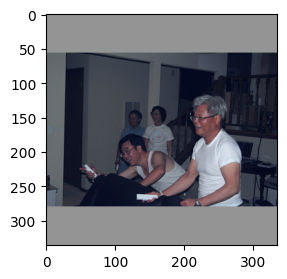

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Provide a one-sentence caption for the provided image.
Reference OCR token: VIMAR, arnocanda, P.R.O.T.E.K, Morsetti, elettrici, ELVGX®, VIDEOCITOFONIA, ASSENT, AUTOMAZION, ELEFONIA, PARTNER, OsiSense, EAMASTROLASH, INSTALLATORE, LIFICATO, ACCIAI, FABRIZ, ELVOX, FONIA, VIASILVANI, 42/bGALLUZZO, 055/232, VIDEOCIT, AUTOMAZION ASSISTANT: A grimy store window displays products from the Elvox company.


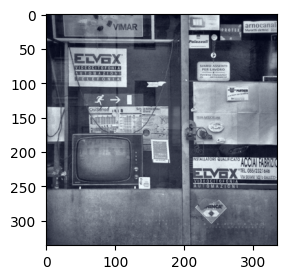

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Can you explain the unusual object the dog is holding and its possible origin? ASSISTANT: In the image, a black dog is sitting on the grass, holding a yellow ring in its mouth. This object appears to be a Frisbee variant, commonly used for playing fetch with dogs. It is likely that the dog's owner or a nearby person, possibly the person visible in the left side of the image, has thrown the Frisbee as part of a game, and the dog has successfully caught it in its mouth. The Frisbee shares a resemblance to a toilet seat, which adds humor to the image, but it is actually a toy designed for dogs to play with and enjoy outdoor activities.


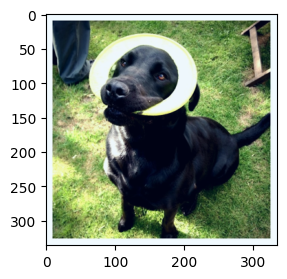

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: What is the toilet paper on?
Answer the question using a single word or phrase. ASSISTANT: Shelf USER: Is the garbage bin made of stainless steel? ASSISTANT: Yes USER: Are there any pictures on the bathroom wall? ASSISTANT: Yes USER: Where in the image is the clean bowl, in the bottom or in the top? ASSISTANT: Bottom USER: Is it an indoors scene? ASSISTANT: Yes USER: What is on the shelf? ASSISTANT: Toilet paper USER: Is the toilet paper on the right or on the left? ASSISTANT: Left USER: What is on the bathroom wall? ASSISTANT: Picture USER: What's the waste basket made of? ASSISTANT: Metal USER: Is the clean bowl to the right or to the left of the garbage can? ASSISTANT: Right USER: Is the trash can on the left side? ASSISTANT: Yes USER: Does the bathroom sink have the same color as the brush? ASSISTANT: Yes USER: What is the 

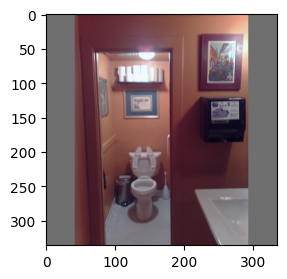

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Do you see either a green scarf or hat?
Answer the question using a single word or phrase. ASSISTANT: No USER: Who is wearing the hat? ASSISTANT: Man USER: Which kind of vehicle is it? ASSISTANT: Train USER: Are there both a window and a door in this image? ASSISTANT: No USER: Do you see a door? ASSISTANT: No USER: Is he riding a horse? ASSISTANT: No USER: What is he on? ASSISTANT: Bike


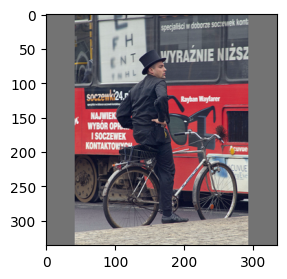

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: What might be the reason behind the outfielder's positioning? ASSISTANT: The outfielder might be positioned in his current spot based on various factors, including the batter's hitting tendencies, the ongoing game's situation, the pitcher's strategy, and the field's dimensions. Analyzing these factors helps outfielders position themselves more effectively to anticipate and respond to the ball's direction and trajectory, increasing the likelihood of catching the ball or making a successful play. Each baseball player has their own unique hitting skills, and the outfielder may be using both past observations and his experience to position himself advantageously. Additionally, the pitcher's choice of pitches and the current score may also influence the outfielder's placement to maximize the defense's efficiency. Ultimately, the out

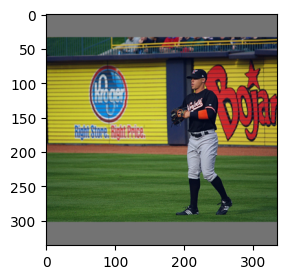

<s> A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Does the horse's tail have orange color?
Answer the question using a single word or phrase. ASSISTANT: No</s> USER: Are there both a helmet and a bike in the image? ASSISTANT: No</s> USER: What type of animal jumps over the hurdle? ASSISTANT: Horse</s><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PA

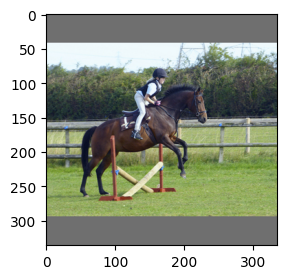

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Is this person alone?
Answer the question using a single word or phrase. ASSISTANT: No USER: Is the man smiling? ASSISTANT: Yes USER: Is this man writing? ASSISTANT: No USER: Who seems more happier? ASSISTANT: Men USER: How many people in this photo appear to be holding gaming controllers? ASSISTANT: 2 USER: What is on the man's wrist? ASSISTANT: Watch USER: What is in the guys hand? ASSISTANT: Wii remote USER: Are they inside? ASSISTANT: Yes USER: What color is his hair? ASSISTANT: Gray USER: What part of this man's outfit is missing? ASSISTANT: Shirt USER: Is this a test waiting room? ASSISTANT: No USER: Is the man wearing a tie? ASSISTANT: No USER: What is the person in white t-shirt holding? ASSISTANT: Wii remote USER: What kind of electronic device is the man using? ASSISTANT: Wii USER: Is anyone else in the room with the 

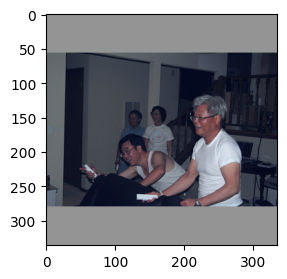

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Provide a one-sentence caption for the provided image.
Reference OCR token: VIMAR, arnocanda, P.R.O.T.E.K, Morsetti, elettrici, ELVGX®, VIDEOCITOFONIA, ASSENT, AUTOMAZION, ELEFONIA, PARTNER, OsiSense, EAMASTROLASH, INSTALLATORE, LIFICATO, ACCIAI, FABRIZ, ELVOX, FONIA, VIASILVANI, 42/bGALLUZZO, 055/232, VIDEOCIT, AUTOMAZION ASSISTANT: A grimy store window displays products from the Elvox company.


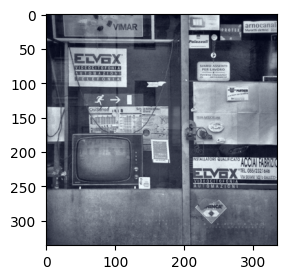

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Can you explain the unusual object the dog is holding and its possible origin? ASSISTANT: In the image, a black dog is sitting on the grass, holding a yellow ring in its mouth. This object appears to be a Frisbee variant, commonly used for playing fetch with dogs. It is likely that the dog's owner or a nearby person, possibly the person visible in the left side of the image, has thrown the Frisbee as part of a game, and the dog has successfully caught it in its mouth. The Frisbee shares a resemblance to a toilet seat, which adds humor to the image, but it is actually a toy designed for dogs to play with and enjoy outdoor activities.


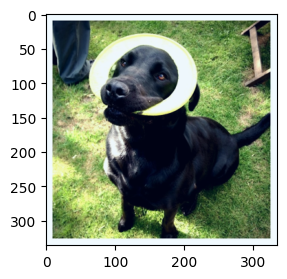

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: What is the toilet paper on?
Answer the question using a single word or phrase. ASSISTANT: Shelf USER: Is the garbage bin made of stainless steel? ASSISTANT: Yes USER: Are there any pictures on the bathroom wall? ASSISTANT: Yes USER: Where in the image is the clean bowl, in the bottom or in the top? ASSISTANT: Bottom USER: Is it an indoors scene? ASSISTANT: Yes USER: What is on the shelf? ASSISTANT: Toilet paper USER: Is the toilet paper on the right or on the left? ASSISTANT: Left USER: What is on the bathroom wall? ASSISTANT: Picture USER: What's the waste basket made of? ASSISTANT: Metal USER: Is the clean bowl to the right or to the left of the garbage can? ASSISTANT: Right USER: Is the trash can on the left side? ASSISTANT: Yes USER: Does the bathroom sink have the same color as the brush? ASSISTANT: Yes USER: What is the 

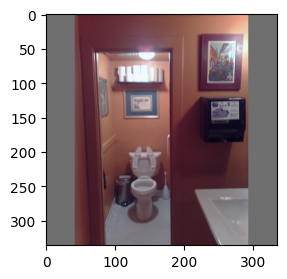

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Do you see either a green scarf or hat?
Answer the question using a single word or phrase. ASSISTANT: No USER: Who is wearing the hat? ASSISTANT: Man USER: Which kind of vehicle is it? ASSISTANT: Train USER: Are there both a window and a door in this image? ASSISTANT: No USER: Do you see a door? ASSISTANT: No USER: Is he riding a horse? ASSISTANT: No USER: What is he on? ASSISTANT: Bike


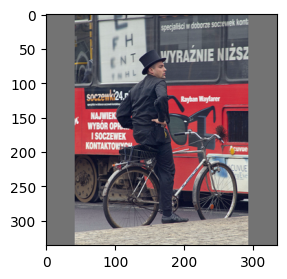

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: What might be the reason behind the outfielder's positioning? ASSISTANT: The outfielder might be positioned in his current spot based on various factors, including the batter's hitting tendencies, the ongoing game's situation, the pitcher's strategy, and the field's dimensions. Analyzing these factors helps outfielders position themselves more effectively to anticipate and respond to the ball's direction and trajectory, increasing the likelihood of catching the ball or making a successful play. Each baseball player has their own unique hitting skills, and the outfielder may be using both past observations and his experience to position himself advantageously. Additionally, the pitcher's choice of pitches and the current score may also influence the outfielder's placement to maximize the defense's efficiency. Ultimately, the out

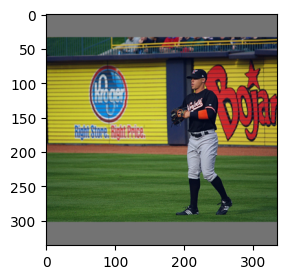

<s> A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Does the horse's tail have orange color?
Answer the question using a single word or phrase. ASSISTANT: No</s> USER: Are there both a helmet and a bike in the image? ASSISTANT: No</s> USER: What type of animal jumps over the hurdle? ASSISTANT: Horse</s><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PA

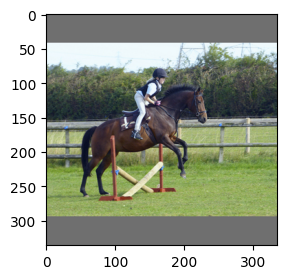

In [4]:
#projected_patch_embeddings, input_embeddings, patch_features, input_ids, projected_patch_attention_mask, attention_mask = get_embeddings(vlm)
projected_patch_embeddings_aligned, input_embeddings_aligned, patch_features_aligned, input_ids_aligned, projected_patch_attention_mask_aligned, attention_mask_aligned = get_embeddings(vlm_aligned)
projected_patch_embeddings_finetuned, input_embeddings_finetuned, patch_features_finetuned, input_ids_finetuned, projected_patch_attention_mask_finetuned, attention_mask_finetuned = get_embeddings(vlm_finetuned)

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Are there any beds or tables that are not blue?
Answer the question using a single word or phrase. ASSISTANT: No USER: What animal is lying on the blanket in this photo? ASSISTANT: Dog USER: Do you think the stuffed animal behind the dog is orange or black? ASSISTANT: Orange USER: What is the small animal covered by? ASSISTANT: Stuffed animal USER: How is the toy that the animal that is not large is covered by called? ASSISTANT: Stuffed animal USER: What animal is lying on the blue blanket? ASSISTANT: Dog USER: Is the stuffed animal that looks gray covering a squirrel? ASSISTANT: No USER: Are there any stuffed animals on top of the bed? ASSISTANT: Yes USER: What is the toy that is on top of the dog? ASSISTANT: Stuffed animal USER: What is the name of the toy above the pillow that is to the left of the dog? ASSISTANT: Stuffed an

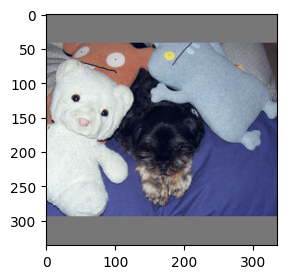

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: What do you think is the color of the shirt?
Answer the question using a single word or phrase. ASSISTANT: Pink USER: Who is younger, the child or the woman? ASSISTANT: Child USER: Are both the tree and the hedge the same color? ASSISTANT: Yes USER: Is the kid on the left side or on the right of the photo? ASSISTANT: Left USER: Who is wearing a hat? ASSISTANT: Child USER: Are there any brooms or life jackets? ASSISTANT: No USER: Is the woman to the left or to the right of the frisbee on the left side? ASSISTANT: Right USER: What is the child to the left of the woman wearing? ASSISTANT: Hat USER: What is the child wearing? ASSISTANT: Hat USER: Who is wearing the hat? ASSISTANT: Child


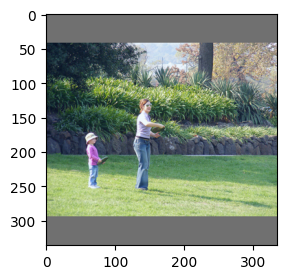

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Are there lamps or rugs in this photo?
Answer the question using a single word or phrase. ASSISTANT: No USER: What is the color of the spray can? ASSISTANT: White USER: Are the books in the bottom part or in the top of the image? ASSISTANT: Top USER: What kind of furniture is to the left of the spray can? ASSISTANT: Bookshelf USER: Which side is the chair on? ASSISTANT: Left


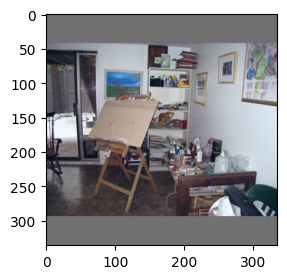

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Is the small clock to the left or to the right of the woman on the left of the photo?
Answer the question using a single word or phrase. ASSISTANT: Right USER: Is the clock to the left of the picture on the left side of the image? ASSISTANT: No USER: How large is the clock to the right of the woman? ASSISTANT: Small USER: What is wearing a dress? ASSISTANT: Figurine USER: Are there both clocks and mannequins in this photo? ASSISTANT: No USER: Which place is it? ASSISTANT: Store USER: Are there women in the image? ASSISTANT: Yes USER: What is wearing a coat? ASSISTANT: Figurine USER: What is wearing a hat? ASSISTANT: Statue USER: What is wearing the hat? ASSISTANT: Statue USER: What is on the building? ASSISTANT: Clock USER: What's wearing the coat? ASSISTANT: Figurine USER: In which part of the image are the toys, the bottom or

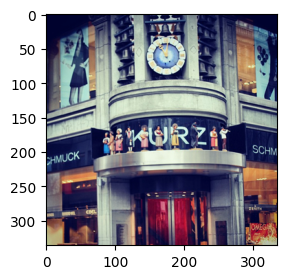

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Does the water look calm?
Answer the question using a single word or phrase. ASSISTANT: Yes USER: Do you see a boat in the picture? ASSISTANT: Yes USER: Are there any kites in the sky? ASSISTANT: No USER: What is the aircraft that is above the calm water called? ASSISTANT: Airplane


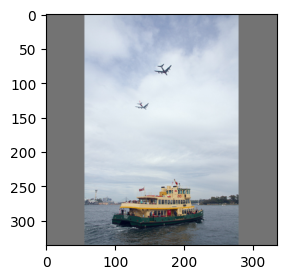

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: What's on the train tracks?
Answer the question using a single word or phrase. ASSISTANT: Train USER: Do you see both cars and trains? ASSISTANT: Yes USER: Are there either life vests or chimneys? ASSISTANT: No USER: Where is the snow? ASSISTANT: Mountain USER: Is the white building behind the vehicle on the railroad tracks? ASSISTANT: Yes USER: Is the car to the right of the train car that looks red? ASSISTANT: No USER: What's located on the edge of the grass? ASSISTANT: Rock USER: What is covered with snow? ASSISTANT: Mountain USER: What is in front of the white building? ASSISTANT: Train USER: Is the train car on the left side? ASSISTANT: Yes USER: What is on the train tracks? ASSISTANT: Train USER: Is the car to the right of the train car silver or green? ASSISTANT: Green USER: Does the sky that is not ugly look clear? ASSI

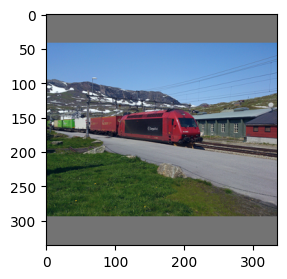

<s> A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Is the brick floor red and large?
Answer the question using a single word or phrase. ASSISTANT: Yes</s> USER: What makes up the floor, brick or hardwood? ASSISTANT: Brick</s> USER: What is the floor made of? ASSISTANT: Brick</s> USER: Do the shoes seem to be black? ASSISTANT: Yes</s> USER: Are there people to the right of the suitcase? ASSISTANT: Yes</s> USER: Does the person that is to the left of the backpack seem to be waiting? ASSISTANT: Yes</s> USER: What is the man doing? ASSISTANT: Waiting</s> USER: Does the jacket look blue? ASSISTANT: Yes</s> USER: Are there any frisbees or trays? ASSISTANT: No</s> USER: Are there any windows? ASSISTANT: Yes</s> USER: Do you see any black backpacks or cars? ASSISTANT: Yes</s> USER: Where is the man? ASSISTANT: Floor</s> USER: Is the man holding a racket? ASSISTANT: No</s> USER: Do 

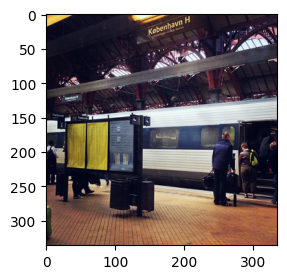

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Are there any beds or tables that are not blue?
Answer the question using a single word or phrase. ASSISTANT: No USER: What animal is lying on the blanket in this photo? ASSISTANT: Dog USER: Do you think the stuffed animal behind the dog is orange or black? ASSISTANT: Orange USER: What is the small animal covered by? ASSISTANT: Stuffed animal USER: How is the toy that the animal that is not large is covered by called? ASSISTANT: Stuffed animal USER: What animal is lying on the blue blanket? ASSISTANT: Dog USER: Is the stuffed animal that looks gray covering a squirrel? ASSISTANT: No USER: Are there any stuffed animals on top of the bed? ASSISTANT: Yes USER: What is the toy that is on top of the dog? ASSISTANT: Stuffed animal USER: What is the name of the toy above the pillow that is to the left of the dog? ASSISTANT: Stuffed an

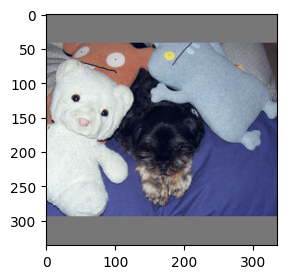

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: What do you think is the color of the shirt?
Answer the question using a single word or phrase. ASSISTANT: Pink USER: Who is younger, the child or the woman? ASSISTANT: Child USER: Are both the tree and the hedge the same color? ASSISTANT: Yes USER: Is the kid on the left side or on the right of the photo? ASSISTANT: Left USER: Who is wearing a hat? ASSISTANT: Child USER: Are there any brooms or life jackets? ASSISTANT: No USER: Is the woman to the left or to the right of the frisbee on the left side? ASSISTANT: Right USER: What is the child to the left of the woman wearing? ASSISTANT: Hat USER: What is the child wearing? ASSISTANT: Hat USER: Who is wearing the hat? ASSISTANT: Child


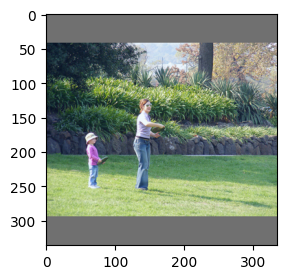

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Are there lamps or rugs in this photo?
Answer the question using a single word or phrase. ASSISTANT: No USER: What is the color of the spray can? ASSISTANT: White USER: Are the books in the bottom part or in the top of the image? ASSISTANT: Top USER: What kind of furniture is to the left of the spray can? ASSISTANT: Bookshelf USER: Which side is the chair on? ASSISTANT: Left


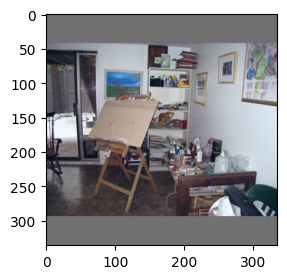

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Is the small clock to the left or to the right of the woman on the left of the photo?
Answer the question using a single word or phrase. ASSISTANT: Right USER: Is the clock to the left of the picture on the left side of the image? ASSISTANT: No USER: How large is the clock to the right of the woman? ASSISTANT: Small USER: What is wearing a dress? ASSISTANT: Figurine USER: Are there both clocks and mannequins in this photo? ASSISTANT: No USER: Which place is it? ASSISTANT: Store USER: Are there women in the image? ASSISTANT: Yes USER: What is wearing a coat? ASSISTANT: Figurine USER: What is wearing a hat? ASSISTANT: Statue USER: What is wearing the hat? ASSISTANT: Statue USER: What is on the building? ASSISTANT: Clock USER: What's wearing the coat? ASSISTANT: Figurine USER: In which part of the image are the toys, the bottom or

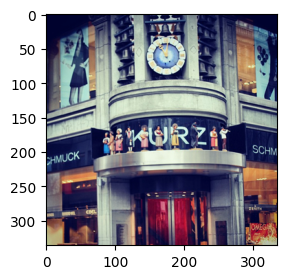

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Does the water look calm?
Answer the question using a single word or phrase. ASSISTANT: Yes USER: Do you see a boat in the picture? ASSISTANT: Yes USER: Are there any kites in the sky? ASSISTANT: No USER: What is the aircraft that is above the calm water called? ASSISTANT: Airplane


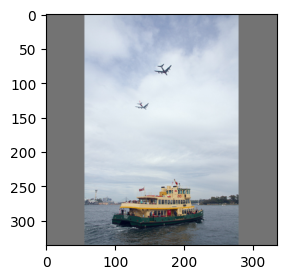

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: What's on the train tracks?
Answer the question using a single word or phrase. ASSISTANT: Train USER: Do you see both cars and trains? ASSISTANT: Yes USER: Are there either life vests or chimneys? ASSISTANT: No USER: Where is the snow? ASSISTANT: Mountain USER: Is the white building behind the vehicle on the railroad tracks? ASSISTANT: Yes USER: Is the car to the right of the train car that looks red? ASSISTANT: No USER: What's located on the edge of the grass? ASSISTANT: Rock USER: What is covered with snow? ASSISTANT: Mountain USER: What is in front of the white building? ASSISTANT: Train USER: Is the train car on the left side? ASSISTANT: Yes USER: What is on the train tracks? ASSISTANT: Train USER: Is the car to the right of the train car silver or green? ASSISTANT: Green USER: Does the sky that is not ugly look clear? ASSI

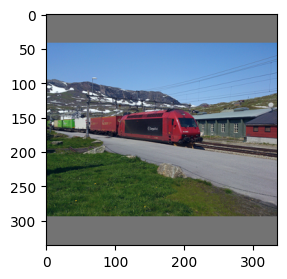

<s> A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Is the brick floor red and large?
Answer the question using a single word or phrase. ASSISTANT: Yes</s> USER: What makes up the floor, brick or hardwood? ASSISTANT: Brick</s> USER: What is the floor made of? ASSISTANT: Brick</s> USER: Do the shoes seem to be black? ASSISTANT: Yes</s> USER: Are there people to the right of the suitcase? ASSISTANT: Yes</s> USER: Does the person that is to the left of the backpack seem to be waiting? ASSISTANT: Yes</s> USER: What is the man doing? ASSISTANT: Waiting</s> USER: Does the jacket look blue? ASSISTANT: Yes</s> USER: Are there any frisbees or trays? ASSISTANT: No</s> USER: Are there any windows? ASSISTANT: Yes</s> USER: Do you see any black backpacks or cars? ASSISTANT: Yes</s> USER: Where is the man? ASSISTANT: Floor</s> USER: Is the man holding a racket? ASSISTANT: No</s> USER: Do 

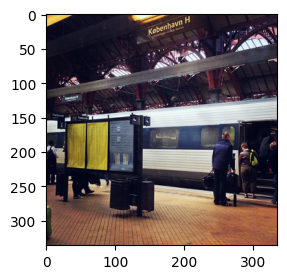

In [5]:
# Measure Baseline
#projected_patch_embeddings, input_embeddings, patch_features, input_ids, projected_patch_attention_mask, attention_mask = get_embeddings(vlm)
projected_patch_embeddings_aligned_baseline, input_embeddings_aligned_baseline, patch_features_aligned_baseline, input_ids_aligned_baseline, projected_patch_attention_mask_aligned_baseline, attention_mask_aligned_baseline = get_embeddings_baseline(vlm_aligned)
projected_patch_embeddings_finetuned_baseline, input_embeddings_finetuned_baseline, patch_features_finetuned_baseline, input_ids_finetuned_baseline, projected_patch_attention_mask_finetuned_baseline, attention_mask_finetuned_baseline = get_embeddings_baseline(vlm_finetuned)


save_path = RUN_DIR.split('/')[-1] + "_embeddings.png"

In [4]:
# Interactive Plots

In [12]:
sample_idx = 6

visualize_embeddings_interactive(input_embeddings_aligned, projected_patch_embeddings_aligned, sample_idx=sample_idx, \
    method='umap', perplexity=30, n_components=2, title=f"Aligned MLLM | Sample {sample_idx}",
    tokenizer = vlm_aligned.model.llm_backbone.tokenizer, input_ids=input_ids_aligned, ignore_token_id=32000)


visualize_embeddings_interactive(input_embeddings_finetuned, projected_patch_embeddings_finetuned, sample_idx=sample_idx, \
    method='umap', perplexity=30, n_components=2, title=f"Finetuned MLLM | Sample {sample_idx}",
    tokenizer = vlm_finetuned.model.llm_backbone.tokenizer, input_ids=input_ids_finetuned, ignore_token_id=32000)
    

Performing dimensionality reduction using UMAP...
Dimensionality reduction completed.


Performing dimensionality reduction using UMAP...
Dimensionality reduction completed.


Performing dimensionality reduction using UMAP. This may take a while...
Dimensionality reduction completed.
Clustering input embeddings into 20 clusters...
Plot saved to reproduction-llava-v15+7b+stage-align+x7_0_embeddings.png


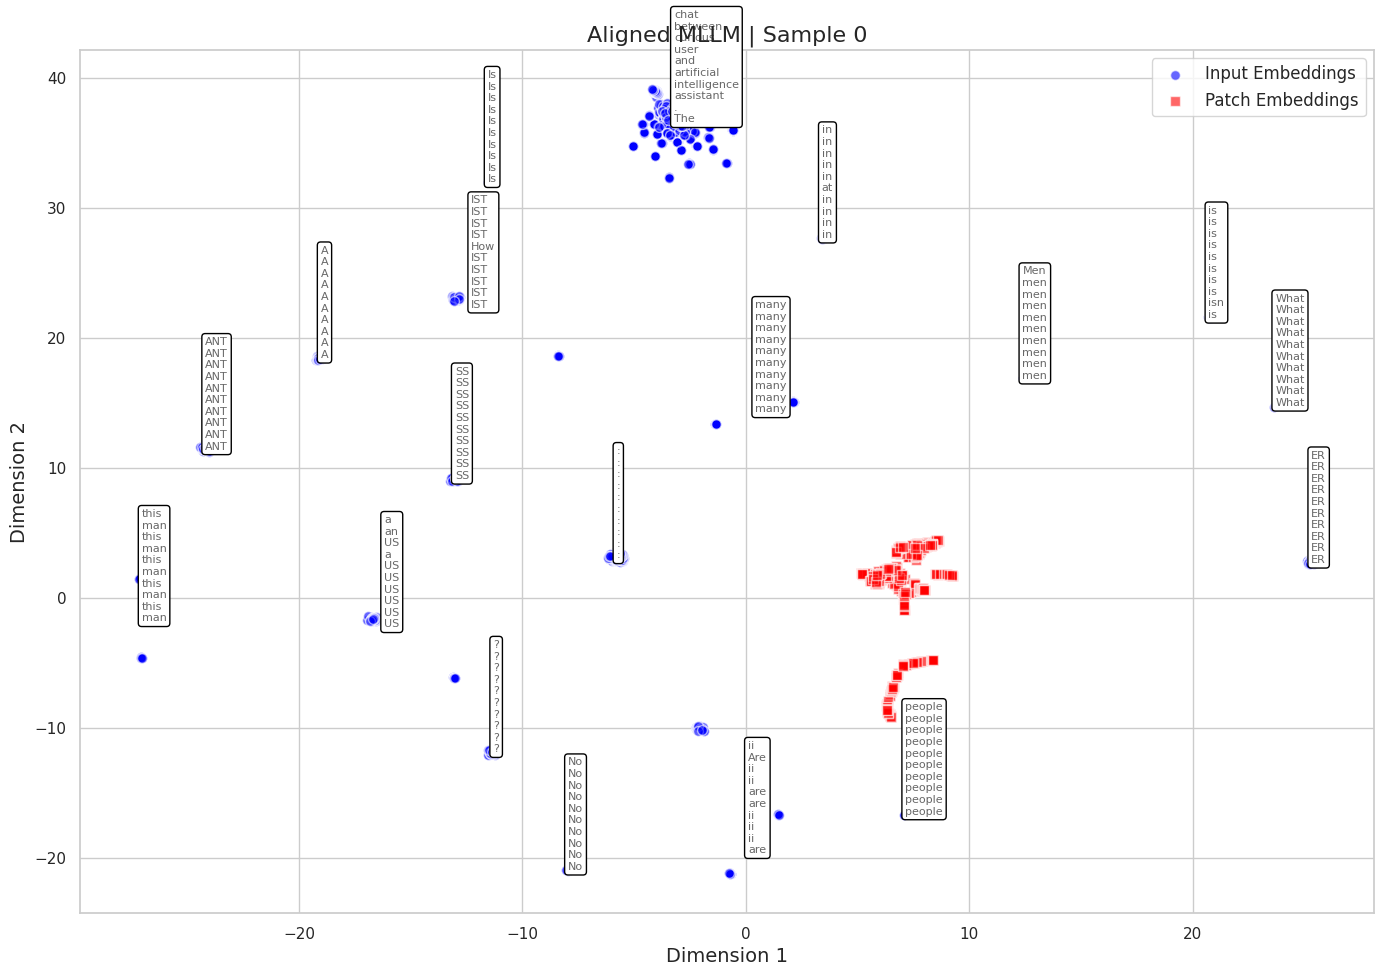

Performing dimensionality reduction using UMAP. This may take a while...
Dimensionality reduction completed.
Clustering input embeddings into 20 clusters...
Plot saved to reproduction-llava-v15+7b+stage-finetune+x7_0_embeddings.png


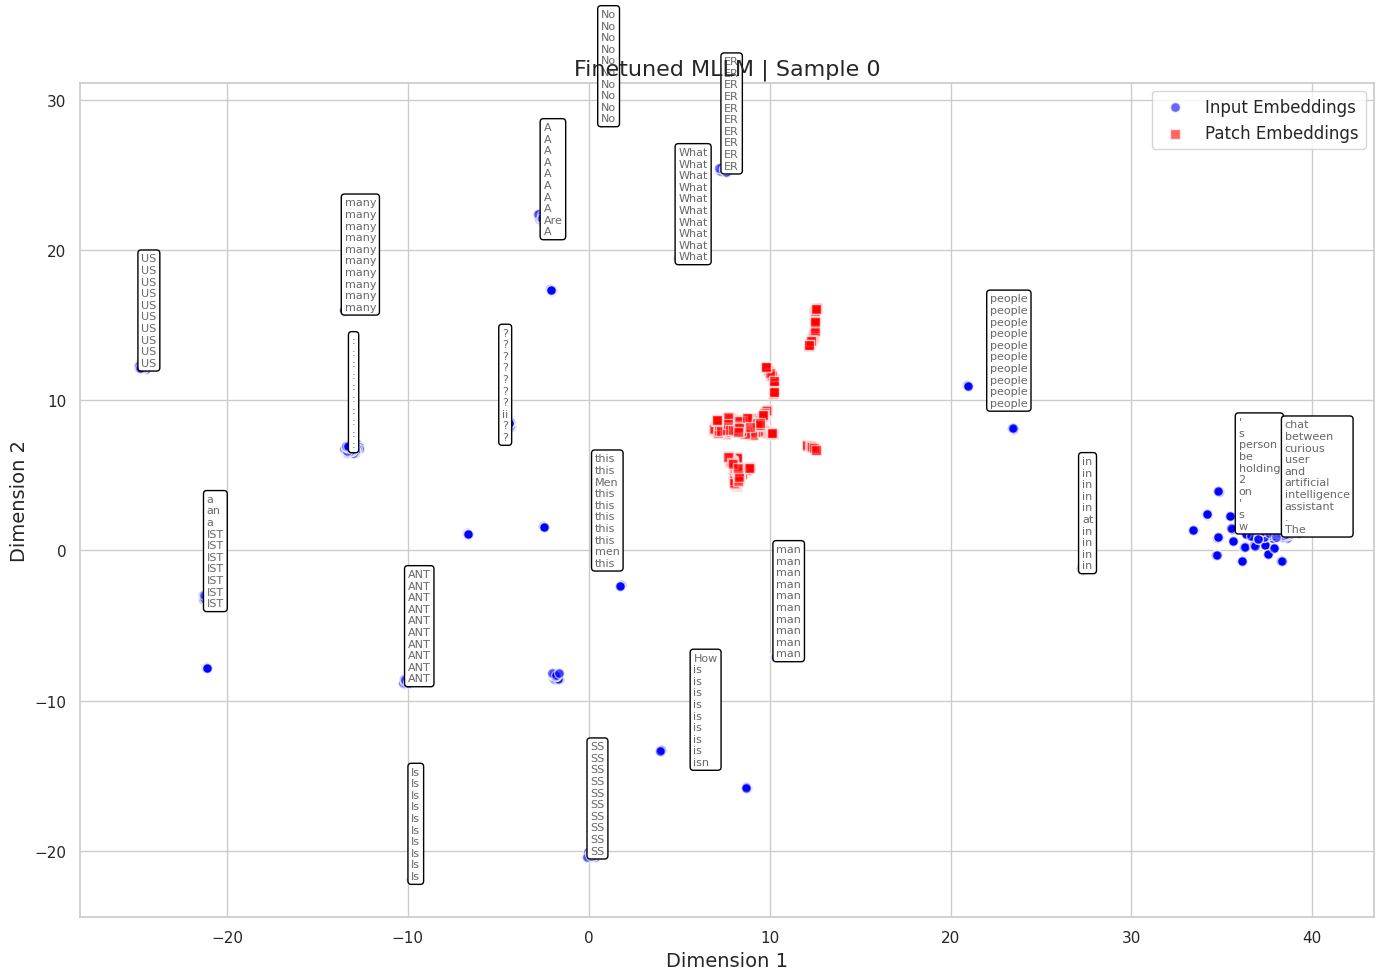

In [15]:
sample_idx = 0
num_clusters = 20
# Construct save paths based on the run directory and sample_idx
save_path_aligned = RUN_DIR_aligned.split('/')[-1] + f"_{sample_idx}_embeddings.png"
save_path_finetuned = RUN_DIR_finetuned.split('/')[-1] + f"_{sample_idx}_embeddings.png"

# Non-interactive visualization for aligned model
visualize_embeddings_cluster(
    input_embeddings_aligned, 
    projected_patch_embeddings_aligned, 
    sample_idx=sample_idx, 
    method='umap', 
    perplexity=30, 
    n_components=2, 
    title=f"Aligned MLLM | Sample {sample_idx}",
    tokenizer=vlm_aligned.model.llm_backbone.tokenizer, 
    input_ids=input_ids_aligned,
    save_path=save_path_aligned,
    num_clusters=num_clusters,
    ignore_token_id=32000
)

# Non-interactive visualization for finetuned model
visualize_embeddings_cluster(
    input_embeddings_finetuned, 
    projected_patch_embeddings_finetuned, 
    sample_idx=sample_idx, 
    method='umap', 
    perplexity=30, 
    n_components=2, 
    title=f"Finetuned MLLM | Sample {sample_idx}",
    tokenizer=vlm_finetuned.model.llm_backbone.tokenizer, 
    input_ids=input_ids_finetuned,
    save_path=save_path_finetuned,
    num_clusters=num_clusters,
    ignore_token_id=32000
)

## Calculate Distance b/w Visual \& Textual Embeddings

In [7]:
import torch
import torch.nn.functional as F

def compute_distances(projected_patch_embeddings: torch.Tensor, input_embeddings: torch.Tensor):
    """
    Compute Euclidean and Cosine distances between projected visual embeddings (patches)
    and input text embeddings (tokens).

    Args:
        projected_patch_embeddings (torch.Tensor): 
            Shape: (batch_size, num_patches, embed_dim)
        input_embeddings (torch.Tensor): 
            Shape: (batch_size, seq_len, embed_dim)

    Returns:
        euclidean_distances (torch.Tensor): 
            Euclidean distances, shape: (batch_size, num_patches, seq_len)
        cosine_distances (torch.Tensor):
            Cosine distances, shape: (batch_size, num_patches, seq_len)
    """
    # Validate shapes
    assert projected_patch_embeddings.dim() == 3, "projected_patch_embeddings must be 3D"
    assert input_embeddings.dim() == 3, "input_embeddings must be 3D"
    assert projected_patch_embeddings.size(0) == input_embeddings.size(0), "Batch sizes must match"
    assert projected_patch_embeddings.size(2) == input_embeddings.size(2), "Embed dims must match"

    bsz, num_patches, embed_dim = projected_patch_embeddings.shape
    _, seq_len, _ = input_embeddings.shape

    # Compute Euclidean distances
    # torch.cdist: Computes pairwise distances between two sets of vectors
    # We need to reshape to (bsz * num_patches, embed_dim) and (bsz * seq_len, embed_dim) to use cdist directly
    # or we can do it batch-wise in a loop. But we can also do a batch cdist in PyTorch 2.0+.
    # If torch < 2.0, we might need to loop over batches or use a trick.
    #
    # If your PyTorch version supports batch mode for cdist, you can do:
    # euclidean_distances = torch.cdist(projected_patch_embeddings, input_embeddings)
    #
    # If not, we can do a loop:
    euclidean_distances_list = []
    for i in range(bsz):
        # shape: (num_patches, seq_len)
        dist = torch.cdist(projected_patch_embeddings[i], input_embeddings[i])
        euclidean_distances_list.append(dist.unsqueeze(0))
    euclidean_distances = torch.cat(euclidean_distances_list, dim=0)

    # Compute Cosine distances
    # Normalize embeddings along the embedding dimension
    proj_norm = F.normalize(projected_patch_embeddings, p=2, dim=-1)  # (bsz, num_patches, embed_dim)
    inp_norm = F.normalize(input_embeddings, p=2, dim=-1)             # (bsz, seq_len, embed_dim)

    # Compute cosine similarity via batch matrix multiplication
    # proj_norm: (bsz, num_patches, embed_dim)
    # inp_norm:  (bsz, seq_len, embed_dim)
    # To do batch matrix mul: we can transpose inp_norm and use torch.matmul:
    # similarity: (bsz, num_patches, seq_len)
    similarity = torch.matmul(proj_norm, inp_norm.transpose(1, 2)) 

    # Cosine distance = 1 - cosine similarity
    cosine_distances = 1.0 - similarity

    return euclidean_distances, cosine_distances

In [8]:
eu_dist_aligned, cos_dist_aligned = compute_distances(projected_patch_embeddings_aligned, input_embeddings_aligned)
eu_dist_finetuned, cos_dist_finetuned = compute_distances(projected_patch_embeddings_finetuned, input_embeddings_finetuned)

eu_dist_text_baseline_aligned, cos_dist_text_baseline_aligned = compute_distances(input_embeddings_aligned_baseline, input_embeddings_aligned)
eu_dist_text_baseline_finetuned, cos_dist_text_baseline_finetuned = compute_distances(input_embeddings_finetuned_baseline, input_embeddings_finetuned)

In [4]:
### single sample heatmap difference

In [18]:
idx = 2
difference_map_eu = eu_dist_finetuned[idx].to(torch.float32).cpu().numpy() - \
                    eu_dist_aligned[idx].to(torch.float32).cpu().numpy()
                    
difference_map_cos = cos_dist_finetuned[idx].to(torch.float32).cpu().numpy() - \
                     cos_dist_aligned[idx].to(torch.float32).cpu().numpy()

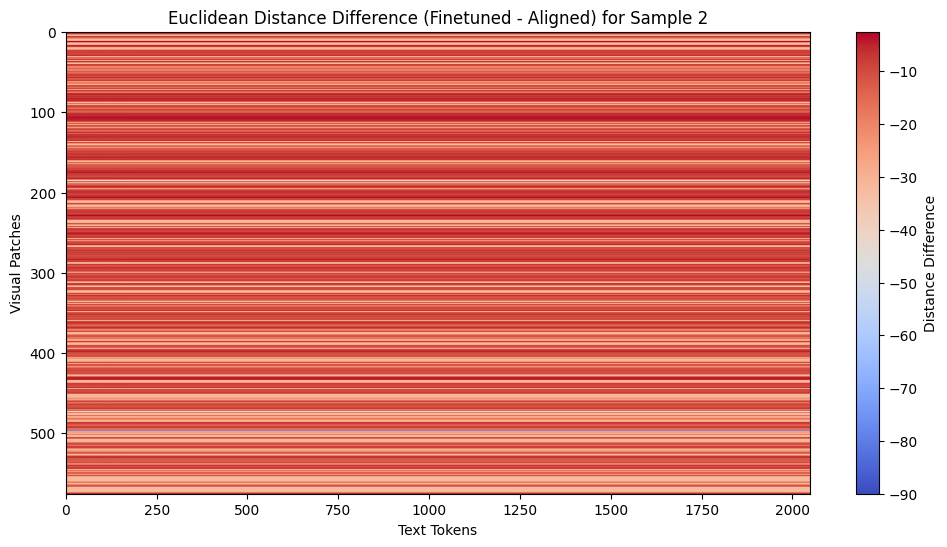

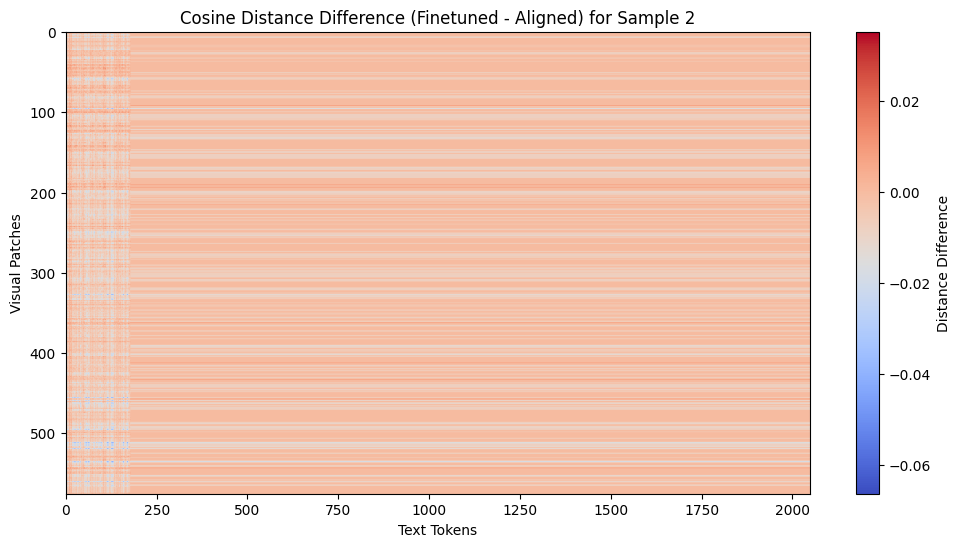

In [19]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
plt.title(f'Euclidean Distance Difference (Finetuned - Aligned) for Sample {idx}')
# aspect='auto' ensures it fits nicely on the figure, and 'coolwarm' gives positive/negative contrast
plt.imshow(difference_map_eu, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Distance Difference')
plt.xlabel('Text Tokens')
plt.ylabel('Visual Patches')
plt.show()

plt.figure(figsize=(12, 6))
plt.title(f'Cosine Distance Difference (Finetuned - Aligned) for Sample {idx}')
plt.imshow(difference_map_cos, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Distance Difference')
plt.xlabel('Text Tokens')
plt.ylabel('Visual Patches')
plt.show()


In [5]:
# Average difference heatmap 

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Compute the difference maps
difference_map_eu = eu_dist_finetuned - eu_dist_aligned  # shape: (8, 576, 2048)
difference_map_cos = cos_dist_finetuned - cos_dist_aligned       # shape: (8, 576, 2048)

# Take the mean across the batch dimension
mean_difference_eu = difference_map_eu.mean(dim=0)  # (576, 2048)
mean_difference_cos = difference_map_cos.mean(dim=0) # (576, 2048)

# Convert to float32 and CPU for plotting
mean_difference_eu_np = mean_difference_eu.to(torch.float32).cpu().numpy()
mean_difference_cos_np = mean_difference_cos.to(torch.float32).cpu().numpy()

# Plot the average Euclidean difference heatmap
plt.figure(figsize=(12, 6))
plt.title('Average Euclidean Distance Difference (Finetuned - Aligned)')
plt.imshow(mean_difference_eu_np, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Distance Difference')
plt.xlabel('Tokens')
plt.ylabel('Patches')
plt.show()

# Plot the average Cosine difference heatmap
plt.figure(figsize=(12, 6))
plt.title('Average Cosine Distance Difference (Finetuned - Aligned)')
plt.imshow(mean_difference_cos_np, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Distance Difference')
plt.xlabel('Tokens')
plt.ylabel('Patches')
plt.show()

NameError: name 'eu_dist_finetuned' is not defined

In [18]:
eu_dist_text_baseline_aligned, eu_dist_text_baseline_finetuned

(tensor([1.0781, 0.4570, 0.3398, 0.6172, 0.2949, 0.5547, 0.8438, 0.3594],
        device='cuda:0', dtype=torch.bfloat16),
 tensor([1.0859, 0.4883, 0.3730, 0.6484, 0.3281, 0.5859, 0.8711, 0.3926],
        device='cuda:0', dtype=torch.bfloat16))

In [10]:
# eu_dist, cos_dist = compute_distances(projected_patch_embeddings, input_embeddings)
# print("Euclidean Distances:", eu_dist.shape)  # (2, 50, 60)
# print("Cosine Distances:", cos_dist.shape)  
eu_dist_aligned, cost_dist_aligned = compute_distances(projected_patch_embeddings_aligned, input_embeddings_aligned)
eu_dist_finetuned, cost_dist_finetuned = compute_distances(projected_patch_embeddings_finetuned, input_embeddings_finetuned)
print(f"Aligned Only: Euclidean Distances: {eu_dist_aligned.shape}, Cosine Distances: {cost_dist_aligned.shape}")
print(f"After MLLM Fine-Tuning: Euclidean Distances: {eu_dist_finetuned.shape}, Cosine Distances: {cost_dist_finetuned.shape}")


eu_dist_text_baseline_aligned, cots_dist_text_baseline_aligned = compute_distances(input_embeddings_aligned_baseline, input_embeddings_aligned)
eu_dist_text_baseline_finetuned, cost_dist_text_baseline_finetuned = compute_distances(input_embeddings_finetuned_baseline, input_embeddings_finetuned)
print(f"Aligned Only: Euclidean Distances: {eu_dist_text_baseline_aligned.shape}, Cosine Distances: {cots_dist_text_baseline_aligned.shape}")
print(f"After MLLM Fine-Tuning: Euclidean Distances: {eu_dist_text_baseline_finetuned.shape}, Cosine Distances: {cost_dist_text_baseline_finetuned.shape}")

Aligned Only: Euclidean Distances: torch.Size([8, 576, 2048]), Cosine Distances: torch.Size([8, 576, 2048])
After MLLM Fine-Tuning: Euclidean Distances: torch.Size([8, 576, 2048]), Cosine Distances: torch.Size([8, 576, 2048])
Aligned Only: Euclidean Distances: torch.Size([8, 1312, 2048]), Cosine Distances: torch.Size([8, 1312, 2048])
After MLLM Fine-Tuning: Euclidean Distances: torch.Size([8, 1312, 2048]), Cosine Distances: torch.Size([8, 1312, 2048])


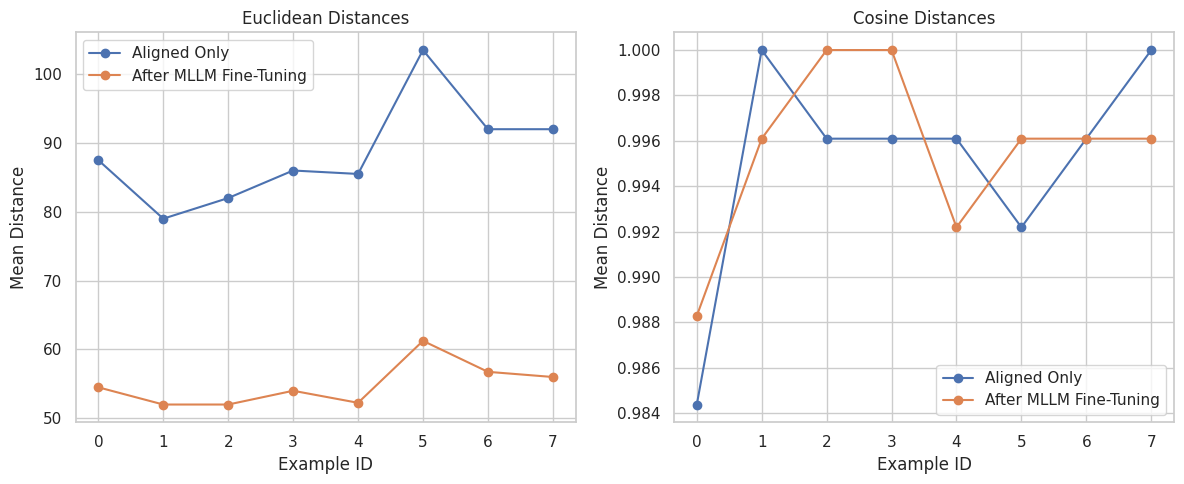

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style='whitegrid')

# Convert PyTorch tensors to float32 if they are bfloat16, then to CPU and NumPy
eu_aligned_np = eu_dist_aligned.to(torch.float32).cpu().numpy()
cos_aligned_np = cost_dist_aligned.to(torch.float32).cpu().numpy()
eu_finetuned_np = eu_dist_finetuned.to(torch.float32).cpu().numpy()
cos_finetuned_np = cost_dist_finetuned.to(torch.float32).cpu().numpy()

num_examples = len(eu_aligned_np)
x = np.arange(num_examples)  # x-values: 0, 1, 2, ...

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Euclidean distances
axes[0].plot(x, eu_aligned_np, marker='o', label='Aligned Only')
axes[0].plot(x, eu_finetuned_np, marker='o', label='After MLLM Fine-Tuning')
axes[0].set_title('Euclidean Distances')
axes[0].set_xlabel('Example ID')
axes[0].set_ylabel('Mean Distance')
axes[0].legend()

# Plot Cosine distances
axes[1].plot(x, cos_aligned_np, marker='o', label='Aligned Only')
axes[1].plot(x, cos_finetuned_np, marker='o', label='After MLLM Fine-Tuning')
axes[1].set_title('Cosine Distances')
axes[1].set_xlabel('Example ID')
axes[1].set_ylabel('Mean Distance')
axes[1].legend()

plt.tight_layout()
plt.show()

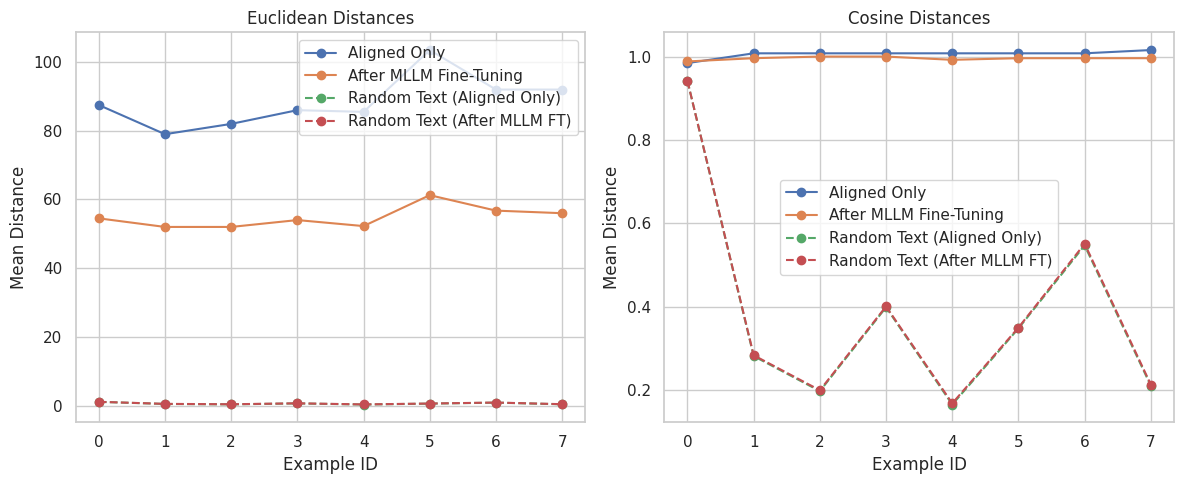

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style='whitegrid')

# Convert PyTorch tensors to float32 if they are bfloat16, then to CPU and NumPy
eu_aligned_np = eu_dist_aligned.to(torch.float32).cpu().numpy()
cos_aligned_np = cost_dist_aligned.to(torch.float32).cpu().numpy()
eu_finetuned_np = eu_dist_finetuned.to(torch.float32).cpu().numpy()
cos_finetuned_np = cost_dist_finetuned.to(torch.float32).cpu().numpy()

# Convert text baseline distances to NumPy as well
eu_dist_text_baseline_aligned_np = eu_dist_text_baseline_aligned.to(torch.float32).cpu().numpy()
cots_dist_text_baseline_aligned_np = cots_dist_text_baseline_aligned.to(torch.float32).cpu().numpy()
eu_dist_text_baseline_finetuned_np = eu_dist_text_baseline_finetuned.to(torch.float32).cpu().numpy()
cost_dist_text_baseline_finetuned_np = cost_dist_text_baseline_finetuned.to(torch.float32).cpu().numpy()

num_examples = len(eu_aligned_np)
x = np.arange(num_examples)  # x-values: 0, 1, 2, ...

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Euclidean distances
axes[0].plot(x, eu_aligned_np, marker='o', label='Aligned Only')
axes[0].plot(x, eu_finetuned_np, marker='o', label='After MLLM Fine-Tuning')
# Add the Random Text baseline for Euclidean distances
axes[0].plot(x, eu_dist_text_baseline_aligned_np, marker='o', label='Random Text (Aligned Only)', linestyle='--')
axes[0].plot(x, eu_dist_text_baseline_finetuned_np, marker='o', label='Random Text (After MLLM FT)', linestyle='--')
axes[0].set_title('Euclidean Distances')
axes[0].set_xlabel('Example ID')
axes[0].set_ylabel('Mean Distance')
axes[0].legend()

# Plot Cosine distances
axes[1].plot(x, cos_aligned_np, marker='o', label='Aligned Only')
axes[1].plot(x, cos_finetuned_np, marker='o', label='After MLLM Fine-Tuning')
# Add the Random Text baseline for Cosine distances
axes[1].plot(x, cots_dist_text_baseline_aligned_np, marker='o', label='Random Text (Aligned Only)', linestyle='--')
axes[1].plot(x, cost_dist_text_baseline_finetuned_np, marker='o', label='Random Text (After MLLM FT)', linestyle='--')
axes[1].set_title('Cosine Distances')
axes[1].set_xlabel('Example ID')
axes[1].set_ylabel('Mean Distance')
axes[1].legend()

plt.tight_layout()
plt.show()

In [9]:
# with text-only baseline

In [14]:
# Save eu_dist_finetuned and aligned.
import pickle
with open('vicuna_eu_dist_finetuned.pkl', 'wb') as f:
    pickle.dump(eu_dist_finetuned, f)
with open('vicuna_eu_dist_aligned.pkl', 'wb') as f:
    pickle.dump(eu_dist_aligned, f)
with open('vicuna_cos_dist_finetuned.pkl', 'wb') as f:
    pickle.dump(cost_dist_finetuned, f)
with open('vicuna_cos_dist_aligned.pkl', 'wb') as f:
    pickle.dump(cost_dist_aligned, f)


Parameter: projector.0.weight
Mean difference: -0.000008
Max absolute difference: 0.006714
--------------------------------------------------
Parameter: projector.0.bias
Mean difference: -0.000309
Max absolute difference: 0.006592
--------------------------------------------------
Parameter: projector.2.weight
Mean difference: 0.000000
Max absolute difference: 0.004761
--------------------------------------------------
Parameter: projector.2.bias
Mean difference: 0.000003
Max absolute difference: 0.002686
--------------------------------------------------


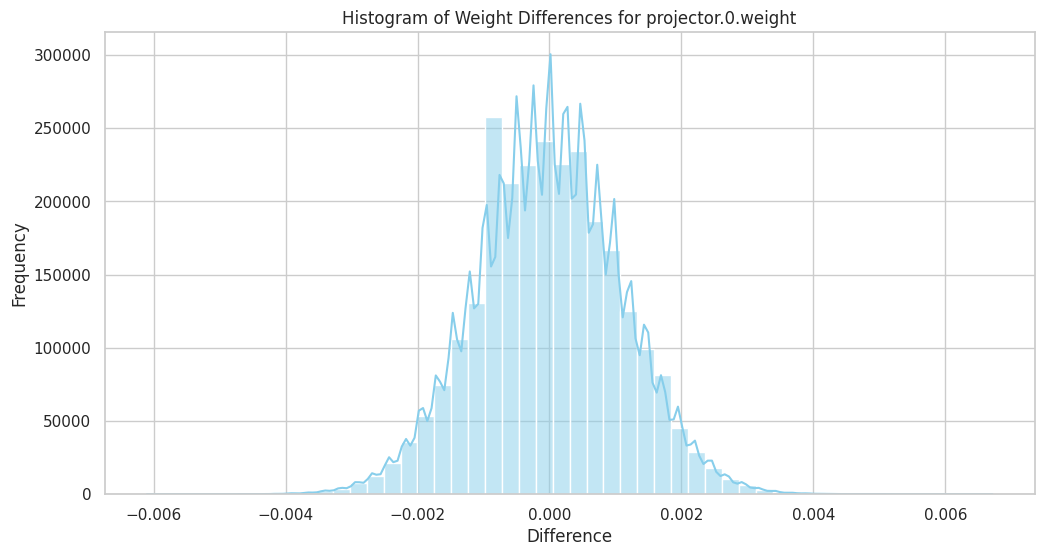

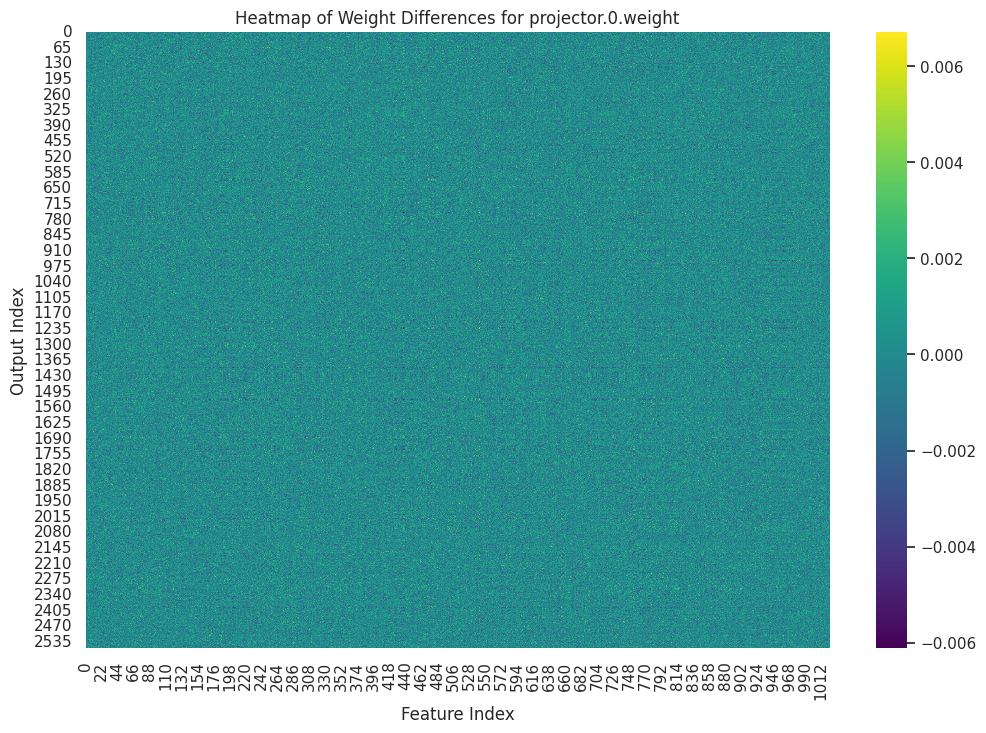

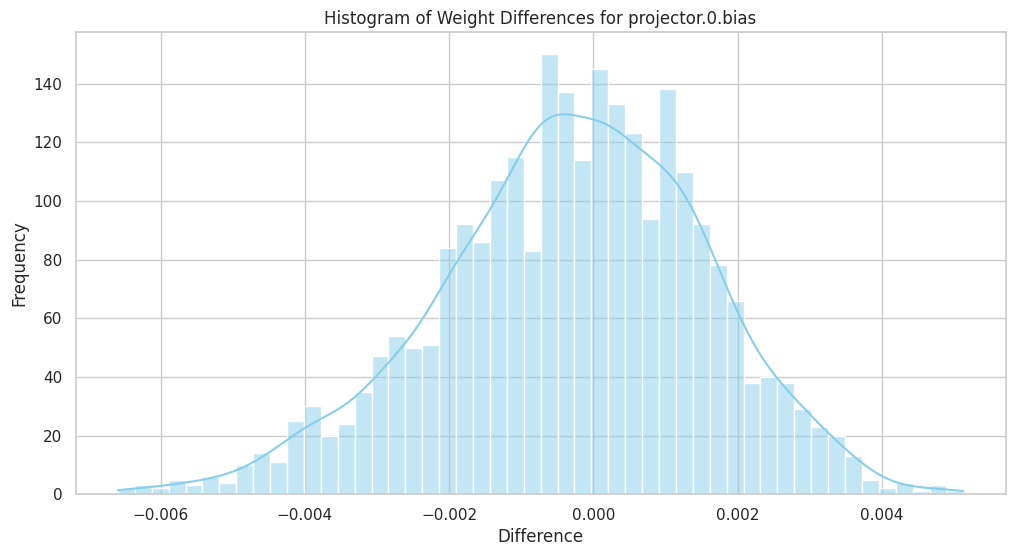

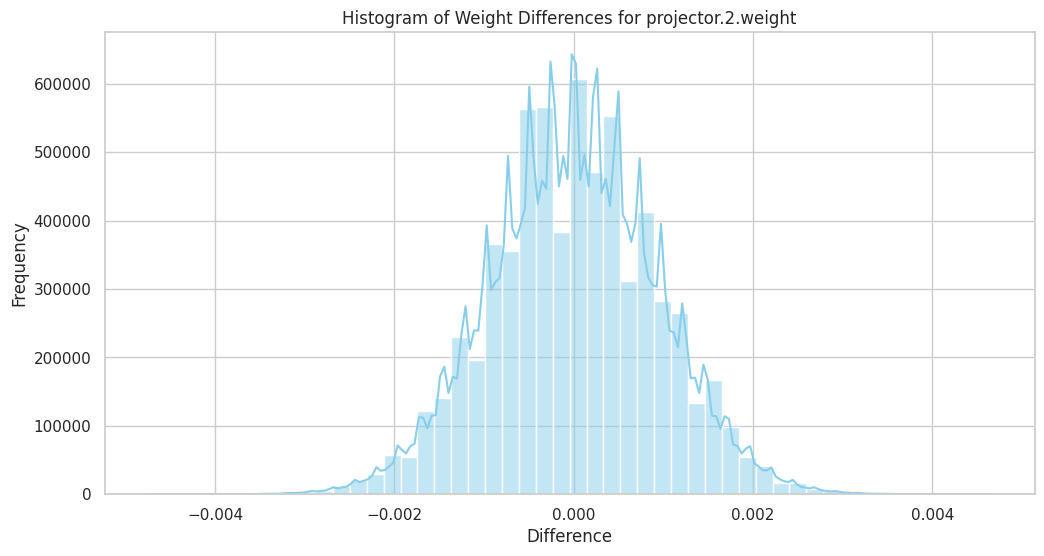

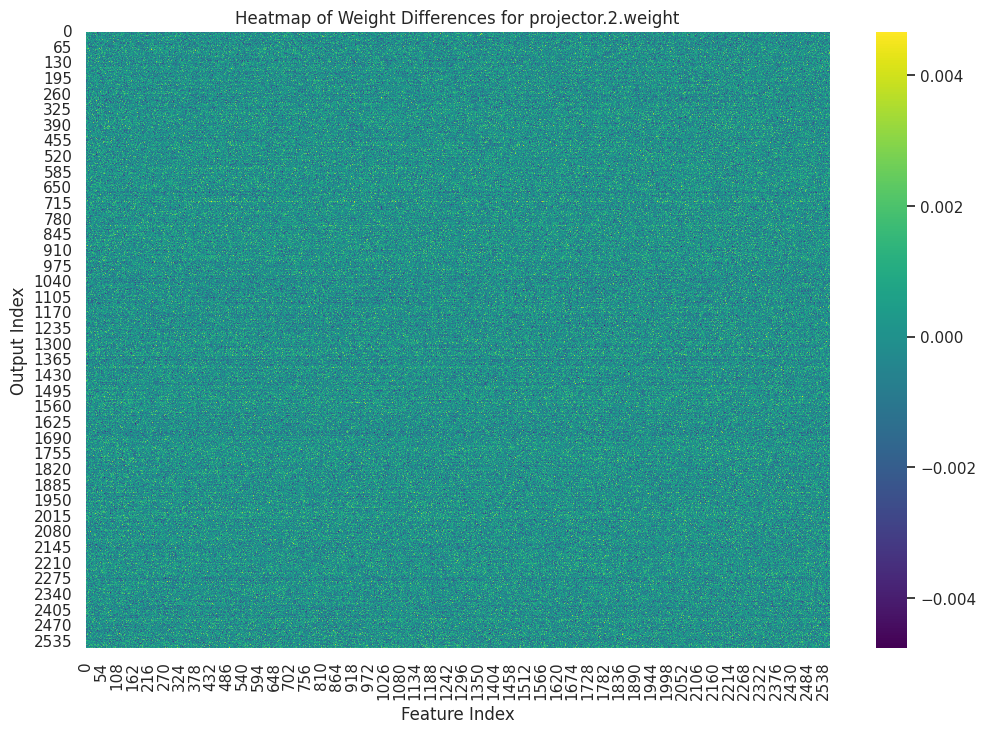

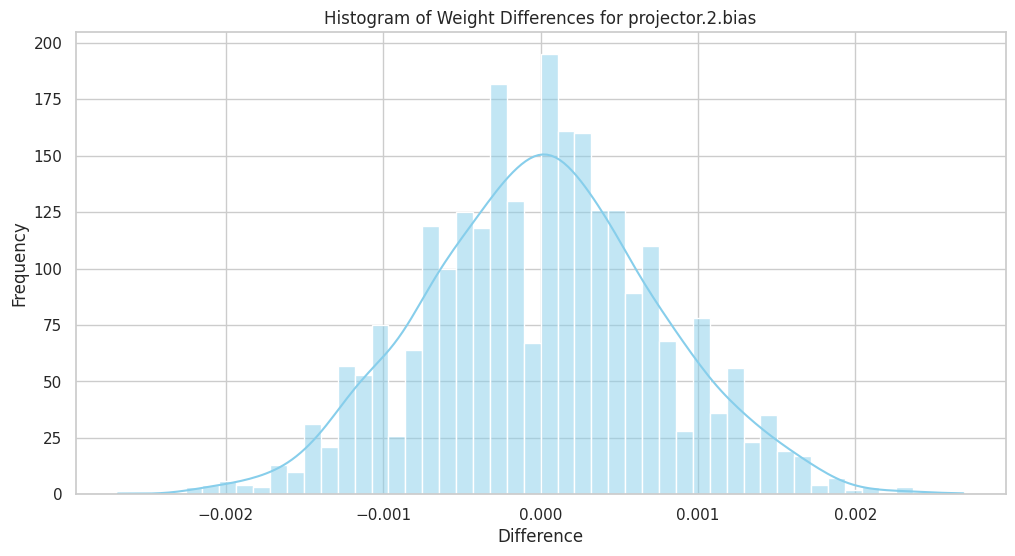

Frobenius Norms of Weight Differences:
projector.0.weight: 1.770531
projector.0.bias: 0.094778
projector.2.weight: 2.365214
projector.2.bias: 0.037739


In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from typing import Optional

def get_projector_state_dict(model):
    """
    Extracts the state dictionary of the projector layer from a model.
    
    Args:
        model: The model instance containing the projector layer.
        
    Returns:
        A state dictionary containing projector parameters.
    """
    if not hasattr(model, 'projector'):
        raise AttributeError("The model does not have a 'projector' attribute.")
    
    projector = model.projector
    return projector.state_dict()

def compare_projector_weights(vlm_finetuned, vlm_aligned):
    """
    Compares the projector weights of two models and returns the differences.
    
    Args:
        vlm_finetuned: The fine-tuned VLM model.
        vlm_aligned: The aligned VLM model.
        
    Returns:
        A dictionary containing the differences of each projector parameter.
    """
    # Extract state dictionaries
    finetuned_state = get_projector_state_dict(vlm_finetuned.model)
    aligned_state = get_projector_state_dict(vlm_aligned.model)
    
    weight_diff = {}
    
    # Iterate through each parameter in the projector
    for key in finetuned_state:
        if key in aligned_state:
            finetuned_param = finetuned_state[key].cpu()
            aligned_param = aligned_state[key].cpu()
            
            # Ensure both parameters have the same shape
            if finetuned_param.shape != aligned_param.shape:
                print(f"Shape mismatch for {key}: {finetuned_param.shape} vs {aligned_param.shape}")
                continue
            
            # Ensure both parameters have the same dtype
            if finetuned_param.dtype != aligned_param.dtype:
                finetuned_param = finetuned_param.float()
                aligned_param = aligned_param.float()
            
            # Compute the difference
            diff = finetuned_param - aligned_param
            
            # Explicitly convert to Float32 to avoid BFloat16 issues
            if diff.dtype == torch.bfloat16:
                diff = diff.float()
            
            weight_diff[key] = diff
            
            # Print summary statistics
            print(f"Parameter: {key}")
            print(f"Mean difference: {diff.mean().item():.6f}")
            print(f"Max absolute difference: {diff.abs().max().item():.6f}")
            print("-" * 50)
        else:
            print(f"Key '{key}' not found in aligned projector.")
    
    return weight_diff

def visualize_weight_differences(weight_diff):
    """
    Visualizes the weight differences using histograms and heatmaps.
    
    Args:
        weight_diff: A dictionary containing the differences of each projector parameter.
    """
    for key, diff in weight_diff.items():
        # Ensure the tensor is in a supported dtype before converting to NumPy
        if diff.dtype not in [torch.float32, torch.float64]:
            print(f"Converting tensor dtype from {diff.dtype} to Float32 for key '{key}'.")
            diff = diff.float()
        
        diff_np = diff.numpy().flatten()
        
        # Histogram of differences
        plt.figure(figsize=(12, 6))
        sns.histplot(diff_np, bins=50, kde=True, color='skyblue')
        plt.title(f'Histogram of Weight Differences for {key}')
        plt.xlabel('Difference')
        plt.ylabel('Frequency')
        plt.show()
        
        # Heatmap of differences (only if 2D)
        if diff.dim() == 2:
            plt.figure(figsize=(12, 8))
            sns.heatmap(diff.numpy(), cmap='viridis')
            plt.title(f'Heatmap of Weight Differences for {key}')
            plt.xlabel('Feature Index')
            plt.ylabel('Output Index')
            plt.show()

def compute_norms(weight_diff):
    """
    Computes and prints the Frobenius norms of the weight differences.
    
    Args:
        weight_diff: A dictionary containing the differences of each projector parameter.
    """
    print("Frobenius Norms of Weight Differences:")
    for key, diff in weight_diff.items():
        norm = torch.norm(diff).item()
        print(f"{key}: {norm:.6f}")

# Example Usage
# Assuming vlm_finetuned and vlm_aligned are already loaded model instances
# and both have a 'model' attribute containing the 'projector' layer.

# Example:
weight_differences = compare_projector_weights(vlm_finetuned, vlm_aligned)
visualize_weight_differences(weight_differences)
compute_norms(weight_differences)

In [14]:
vlm_finetuned.model.projector

PrismaticVLM(
  (vision_backbone): CLIPViTBackbone(
    (featurizer): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-05, elementw

# Plots

Performing dimensionality reduction using UMAP. This may take a while...
Dimensionality reduction completed.
Plot saved to reproduction-align-pythia+2p8b_embeddings.png


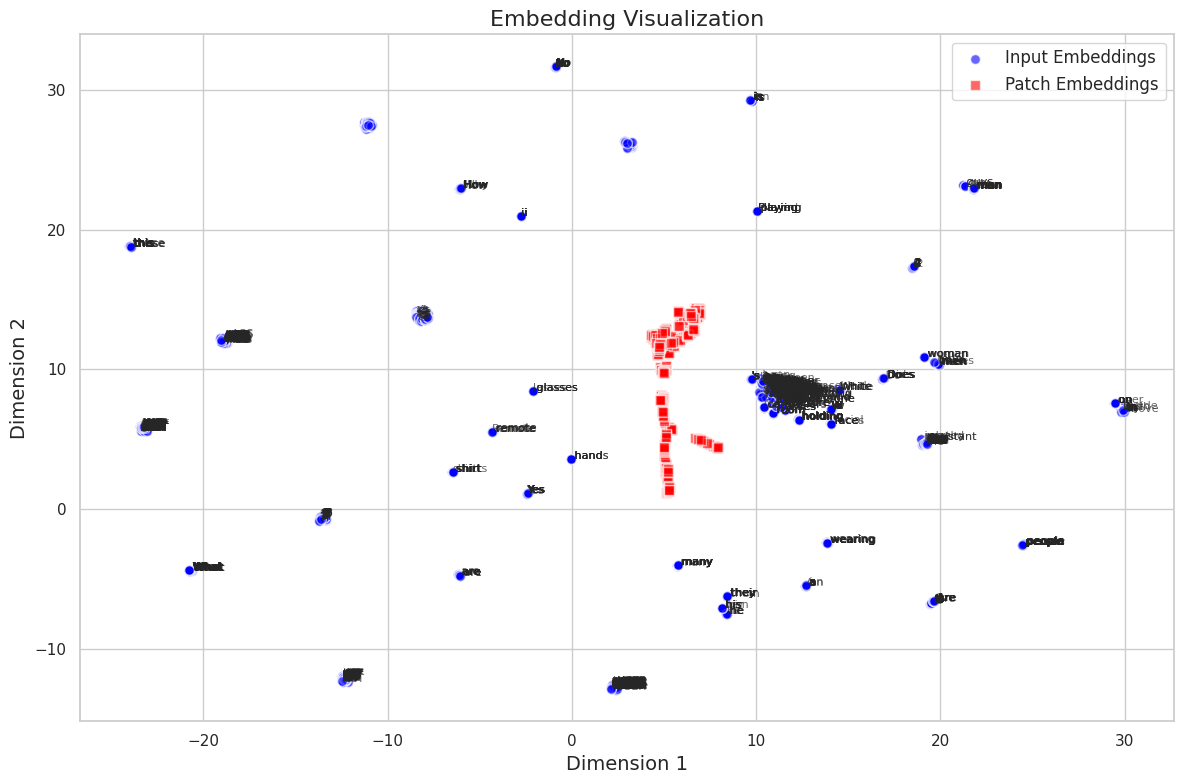

In [6]:
visualize_embeddings(input_embeddings, projected_patch_embeddings, sample_idx=0, \
    method='umap', perplexity=30, n_components=2, figsize=(12, 8), save_path=save_path, title="Embedding Visualization",
    tokenizer = vlm.model.llm_backbone.tokenizer, input_ids=input_ids)

# Embedding Distance from Text Only 2.8B MLLM

In [5]:
tokenizer

NameError: name 'tokenizer' is not defined

In [6]:
vlm_aligned.model.llm_backbone.tokenizer

LlamaTokenizerFast(name_or_path='lmsys/vicuna-7b-v1.5', vocab_size=32000, model_max_length=2048, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<PAD>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32000: AddedToken("<PAD>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

: 

In [4]:
vlm_aligned.model.llm_backbone.llm

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32064, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head):

In [ ]:
vlm_finetuned.model.llm_backbone.llm.gpt_neox.embed_in

In [ ]:
vlm_aligned.model.llm_backbone.llm.gpt_neox.embed_in, vlm_finetuned.model.llm_backbone.llm.gpt_neox.embed_in

(Embedding(50304, 2560), Embedding(50304, 2560))

In [ ]:
vlm_aligned.model.llm_backbone.llm.gpt_neox.embed_in.weight.shape, vlm_finetuned.model.llm_backbone.llm.gpt_neox.embed_in.weight.shape

(torch.Size([50304, 2560]), torch.Size([50304, 2560]))

In [11]:
model

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 2048)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-23): 24 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
          (dense_4h_to_h): Linear(in_features=8192, out_features=2048, bias=True)
  

In [23]:
vlm_aligned.model.llm_backbone.llm.gpt_neox.embed_in.num_embeddings, vlm_finetuned.model.llm_backbone.llm.gpt_neox.embed_in.num_embeddings

(50304, 50304)

## Pythia 2.8B - After MLLM Training

Performing dimensionality reduction using UMAP. This may take a while...
Dimensionality reduction completed.


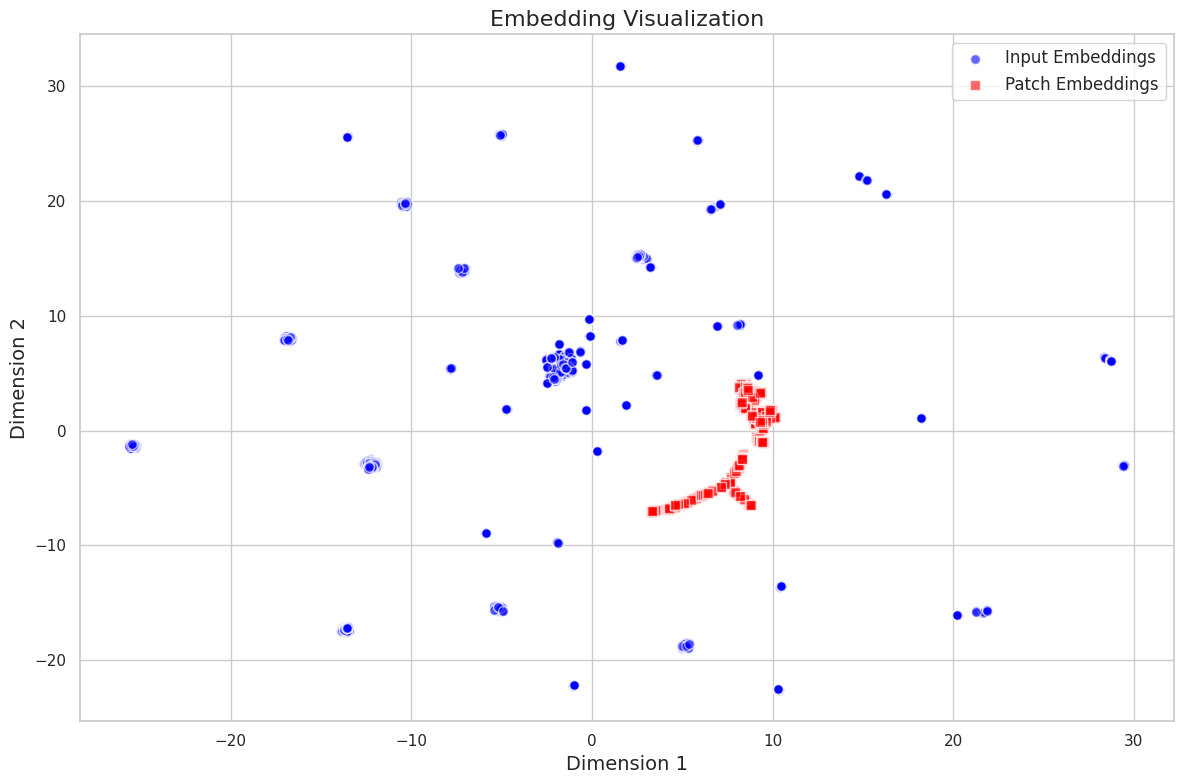

In [11]:
visualize_embeddings(input_embeddings, projected_patch_embeddings, sample_idx=0, method='umap', perplexity=30, n_components=2, figsize=(12, 8), save_path=None, title="Embedding Visualization")

## Pythia 2.8B - Alignment Only

Performing dimensionality reduction using UMAP. This may take a while...
Dimensionality reduction completed.


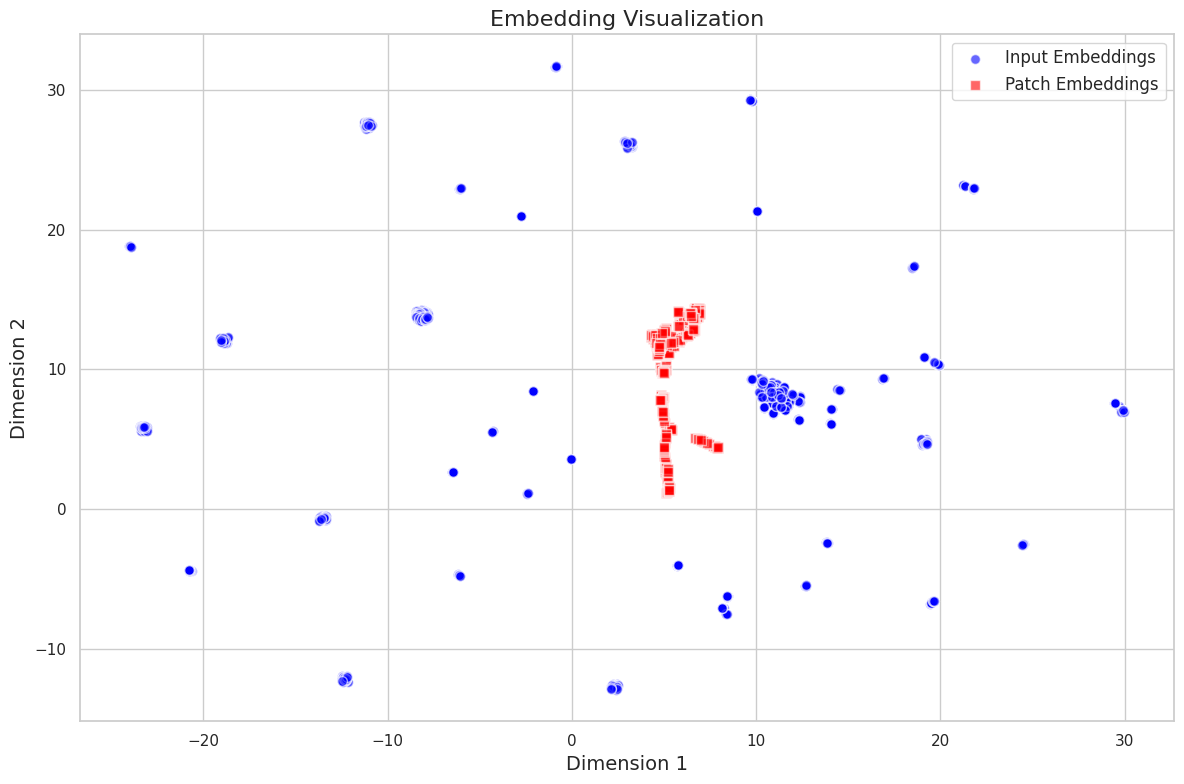

In [9]:
visualize_embeddings(input_embeddings, projected_patch_embeddings, sample_idx=0, method='umap', perplexity=30, n_components=2, figsize=(12, 8), save_path=None, title="Embedding Visualization")

Performing dimensionality reduction using TSNE. This may take a while...


Dimensionality reduction completed.


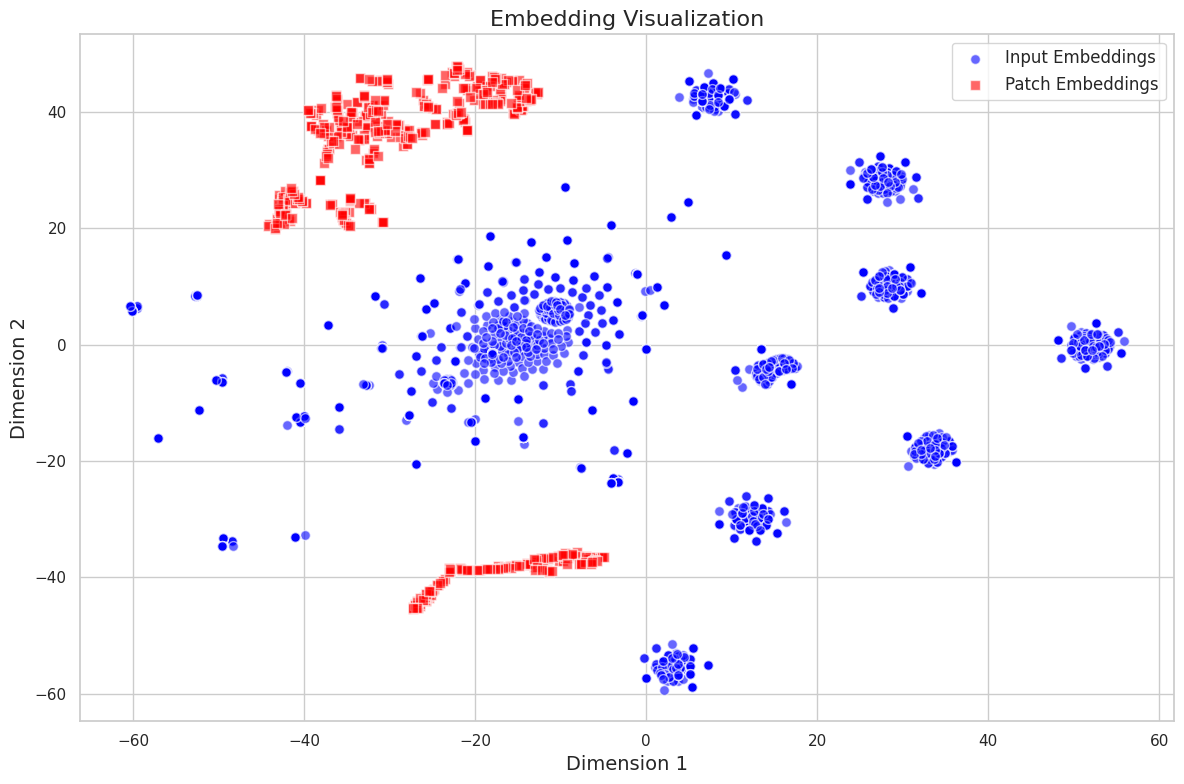

In [56]:
visualize_embeddings(input_embeddings, projected_patch_embeddings, sample_idx=0, method='tsne', perplexity=30, n_components=2, figsize=(12, 8), save_path=None, title="Embedding Visualization")

Performing dimensionality reduction using TSNE. This may take a while...
Dimensionality reduction completed.


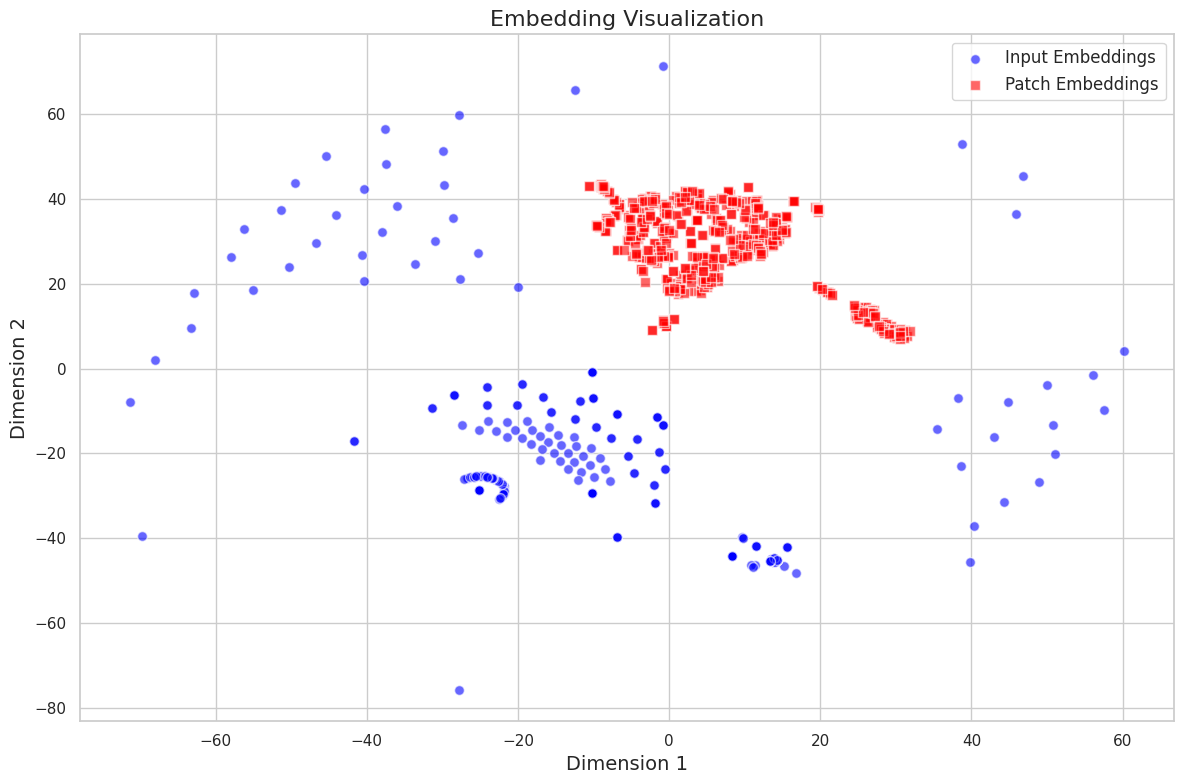

In [57]:
visualize_embeddings(input_embeddings, projected_patch_embeddings, sample_idx=1, method='tsne', perplexity=30, n_components=2, figsize=(12, 8), save_path=None, title="Embedding Visualization")

Performing dimensionality reduction using TSNE. This may take a while...
Dimensionality reduction completed.


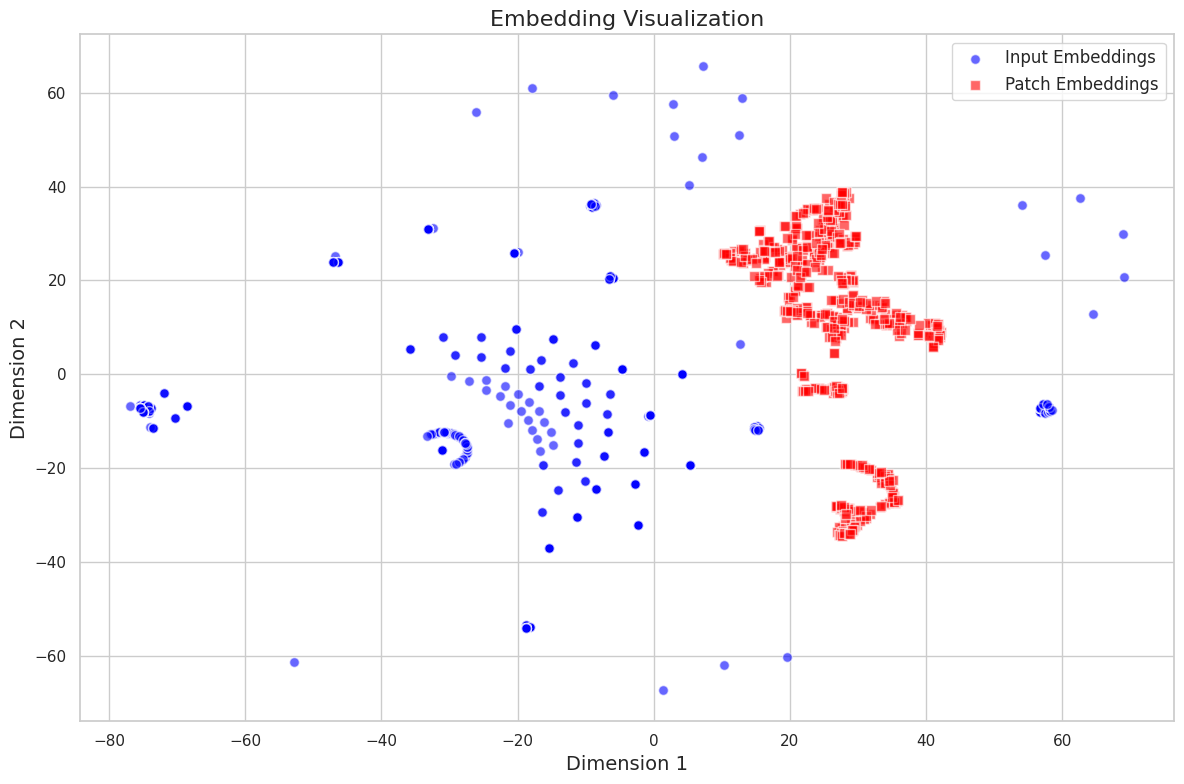

In [27]:
visualize_embeddings(input_embeddings, projected_patch_embeddings, sample_idx=3, method='tsne', perplexity=30, n_components=2, figsize=(12, 8), save_path=None, title="Embedding Visualization")

In [23]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np
from typing import Optional, Union
from transformers import PreTrainedTokenizer  # Ensure you have transformers installed
import warnings

def visualize_embeddings(
    input_embeddings: torch.Tensor,
    patch_embeddings: torch.Tensor,
    input_ids: Optional[torch.Tensor] = None,
    tokenizer: Optional[PreTrainedTokenizer] = None,
    sample_idx: int = 0,
    method: str = 'tsne',  # 'tsne' or 'umap'
    perplexity: int = 30,    # Relevant only if method='tsne'
    n_components: int = 2,
    figsize: tuple = (14, 10),
    save_path: Optional[str] = None,
    title: str = "Embedding Visualization",
    max_points: Optional[int] = None,  # To limit points for performance
    annotate_centroid: bool = False,
    annotate_label: str = "Centroid Token",
):
    """
    Visualizes input token embeddings and image patch embeddings in a lower-dimensional space.
    Optionally annotates the token closest to the centroid of input embeddings.
    
    Args:
        input_embeddings (torch.Tensor): Tensor of shape (batch_size, input_seq_len, embed_dim).
        patch_embeddings (torch.Tensor): Tensor of shape (batch_size, num_patches, embed_dim).
        input_ids (torch.Tensor, optional): Tensor of shape (batch_size, input_seq_len) containing token IDs.
            Required if annotate_centroid is True.
        tokenizer (PreTrainedTokenizer, optional): Tokenizer instance to decode token IDs.
            Required if annotate_centroid is True.
        sample_idx (int, optional): Index of the sample in the batch to visualize. Defaults to 0.
        method (str, optional): Dimensionality reduction method: 'tsne' or 'umap'. Defaults to 'tsne'.
        perplexity (int, optional): Perplexity parameter for t-SNE. Relevant only if method='tsne'. Defaults to 30.
        n_components (int, optional): Number of dimensions for the output. Defaults to 2.
        figsize (tuple, optional): Size of the plot. Defaults to (14, 10).
        save_path (str, optional): If provided, saves the plot to the specified path. Defaults to None.
        title (str, optional): Title of the plot. Defaults to "Embedding Visualization".
        max_points (int, optional): Maximum number of points to visualize per category. Defaults to None.
        annotate_centroid (bool, optional): Whether to annotate the token closest to the centroid. Defaults to False.
        annotate_label (str, optional): Label for the annotated centroid token. Defaults to "Centroid Token".
    
    Returns:
        None. Displays the plot and optionally saves it to a file.
    """
    # Suppress specific warnings
    warnings.filterwarnings("ignore", category=UserWarning)
    
    # Validate sample_idx
    batch_size = input_embeddings.size(0)
    if sample_idx >= batch_size or sample_idx < -batch_size:
        raise IndexError(f"sample_idx {sample_idx} is out of range for batch size {batch_size}.")
    
    # Select the sample
    input_emb_sample = input_embeddings[sample_idx]      # Shape: (input_seq_len, embed_dim)
    patch_emb_sample = patch_embeddings[sample_idx]      # Shape: (num_patches, embed_dim)
    
    # Convert BFloat16 to Float32 if necessary
    if input_emb_sample.dtype == torch.bfloat16:
        input_emb_sample = input_emb_sample.float()
    if patch_emb_sample.dtype == torch.bfloat16:
        patch_emb_sample = patch_emb_sample.float()
    
    # Move to CPU and convert to numpy
    input_emb_np = input_emb_sample.cpu().detach().numpy()
    patch_emb_np = patch_emb_sample.cpu().detach().numpy()
    
    # Check for empty embeddings
    if input_emb_np.size == 0 or patch_emb_np.size == 0:
        raise ValueError("Input or patch embeddings are empty for the selected sample.")
    
    # Optionally subsample for performance
    if max_points is not None:
        # Determine number to sample per category
        num_input = min(input_emb_np.shape[0], max_points)
        num_patch = min(patch_emb_np.shape[0], max_points)
        
        # Randomly sample without replacement
        input_indices = np.random.choice(input_emb_np.shape[0], num_input, replace=False)
        patch_indices = np.random.choice(patch_emb_np.shape[0], num_patch, replace=False)
        
        input_emb_np = input_emb_np[input_indices]
        patch_emb_np = patch_emb_np[patch_indices]
    
    # Create labels
    input_labels = ['Input'] * input_emb_np.shape[0]
    patch_labels = ['Patch'] * patch_emb_np.shape[0]
    
    # Combine embeddings and labels
    combined_embeddings = np.vstack((input_emb_np, patch_emb_np))  # Shape: (input_seq_len + num_patches, embed_dim)
    combined_labels = input_labels + patch_labels                  # Shape: (input_seq_len + num_patches,)
    
    # Dimensionality Reduction
    if method.lower() == 'tsne':
        reducer = TSNE(n_components=n_components, perplexity=perplexity, random_state=42, init='random', n_iter=1000)
    elif method.lower() == 'umap':
        try:
            import umap
        except ImportError:
            raise ImportError("UMAP is not installed. Install it via `pip install umap-learn`.")
        reducer = umap.UMAP(n_components=n_components, random_state=42)
    else:
        raise ValueError(f"Unsupported dimensionality reduction method: {method}. Choose 'tsne' or 'umap'.")
    
    print(f"Performing dimensionality reduction using {method.upper()}. This may take a while...")
    reduced_embeddings = reducer.fit_transform(combined_embeddings)  # Shape: (input_seq_len + num_patches, n_components)
    print("Dimensionality reduction completed.")
    
    # Split the reduced embeddings back into input and patch embeddings
    split_idx = input_emb_np.shape[0]
    input_reduced = reduced_embeddings[:split_idx, :]
    patch_reduced = reduced_embeddings[split_idx:, :]
    
    # Plotting
    plt.figure(figsize=figsize)
    sns.set(style="whitegrid")
    
    # Plot input embeddings
    plt.scatter(
        input_reduced[:, 0],
        input_reduced[:, 1],
        c='blue',
        marker='o',
        label='Input Embeddings',
        alpha=0.6,
        edgecolors='w',
        s=50
    )
    
    # Plot patch embeddings
    plt.scatter(
        patch_reduced[:, 0],
        patch_reduced[:, 1],
        c='red',
        marker='s',
        label='Patch Embeddings',
        alpha=0.6,
        edgecolors='w',
        s=50
    )
    
    # Annotate the centroid token if required
    if annotate_centroid:
        if input_ids is None or tokenizer is None:
            raise ValueError("Both input_ids and tokenizer must be provided to annotate the centroid.")
        
        # Select the sample's input_ids
        sample_input_ids = input_ids[sample_idx]  # Shape: (input_seq_len,)
        
        # Ensure sample_input_ids is a 1D tensor
        if sample_input_ids.dim() != 1:
            raise ValueError(f"input_ids for sample_idx {sample_idx} should be 1D, got shape {sample_input_ids.shape}")
        
        # Convert input_ids to CPU and numpy
        sample_input_ids_np = sample_input_ids.cpu().detach().numpy()
        
        # Compute centroid of input embeddings
        centroid = input_emb_np.mean(axis=0)  # Shape: (embed_dim,)
        
        # Compute Euclidean distances to centroid
        distances = np.linalg.norm(input_emb_np - centroid, axis=1)  # Shape: (num_input,)
        
        # Find the index of the closest embedding to the centroid
        closest_idx = np.argmin(distances)
        
        # Get the corresponding token ID
        closest_token_id = sample_input_ids_np[closest_idx]
        
        # Decode the token ID to get the token string
        try:
            token_str = tokenizer.decode(closest_token_id, skip_special_tokens=True)
        except Exception as e:
            print(f"Error decoding token ID {closest_token_id}: {e}")
            token_str = f"Token ID {closest_token_id}"
        
        # Get the reduced coordinates of the closest embedding
        closest_point = input_reduced[closest_idx]  # Shape: (n_components,)
        
        # Annotate the point on the plot
        plt.scatter(
            closest_point[0],
            closest_point[1],
            c='green',
            marker='X',
            label=f'{annotate_label}: {token_str}',
            s=200,
            edgecolors='k'
        )
        plt.annotate(
            f'{token_str}',
            (closest_point[0], closest_point[1]),
            textcoords="offset points",
            xytext=(0,10),
            ha='center',
            fontsize=12,
            color='green',
            weight='bold'
        )
    
    # Enhancements
    plt.title(title, fontsize=16)
    plt.xlabel("Dimension 1", fontsize=14)
    plt.ylabel("Dimension 2", fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    # Optionally save the plot
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Plot saved to {save_path}")
    
    # Display the plot
    plt.show()


Performing dimensionality reduction using TSNE. This may take a while...
Dimensionality reduction completed.


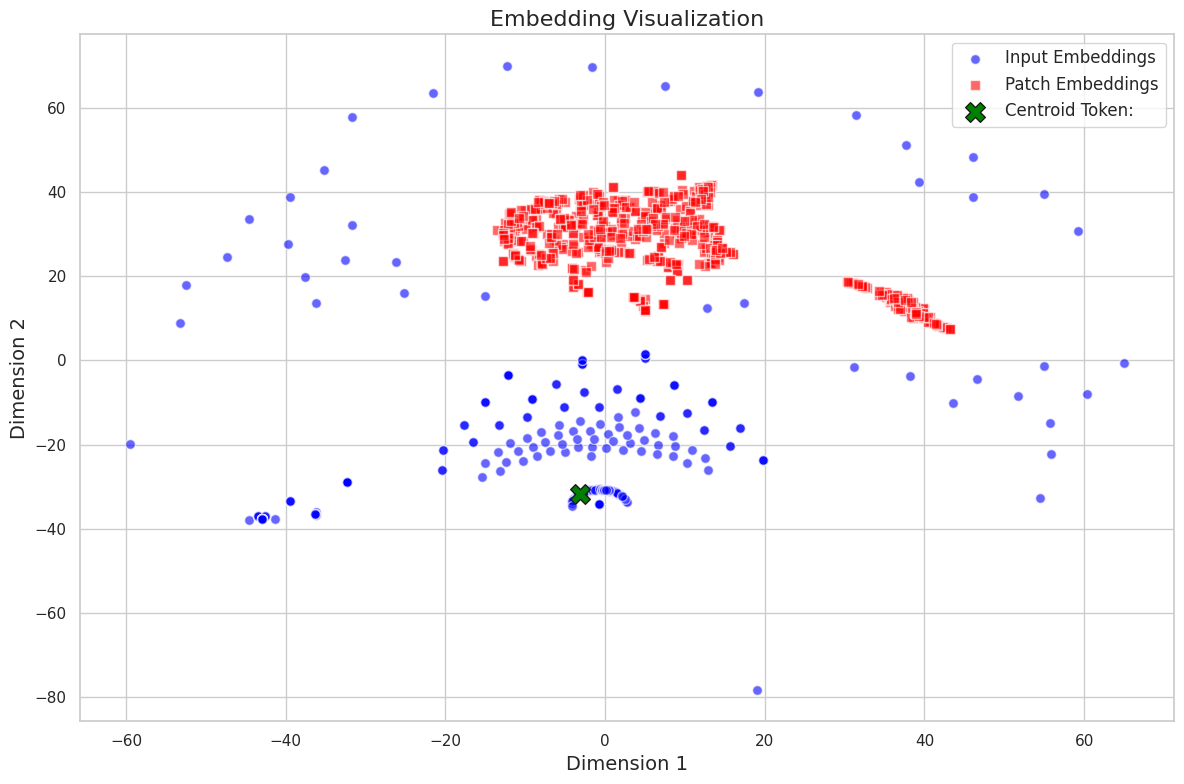

In [26]:
visualize_embeddings(input_embeddings, projected_patch_embeddings, sample_idx=1, method='tsne', perplexity=30, n_components=2, figsize=(12, 8), save_path=None, title="Embedding Visualization", annotate_centroid=True,
        annotate_label="Centroid Token", input_ids=input_ids, tokenizer=tokenizer)

In [48]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def plot_correct_token_rank_distribution(output, fused_labels):
    """
    Plots the distribution of the ranks of the correct tokens within the logits.

    Args:
        output (torch.Tensor): The output from the model, containing logits.
        fused_labels (torch.Tensor): The ground truth labels aligned with the logits.

    Returns:
        None. Displays a plot of the rank distribution.
    """
    # Ensure logits and labels are on the same device
    device = output.logits.device
    logits = output.logits
    labels = fused_labels

    # Align logits and labels by shifting
    # Typically, for language modeling, logits are predictions for the next token
    shift_logits = logits[:, :-1, :].contiguous()  # Shape: (batch_size, seq_len - 1, vocab_size)
    valid_targets = labels[:, 1:].contiguous()     # Shape: (batch_size, seq_len - 1)

    # Create mask for valid targets (labels != -100)
    mask = (valid_targets != -100)  # Shape: (batch_size, seq_len - 1)

    # Replace -100 in labels to avoid indexing errors (temporary placeholder)
    valid_targets_clamped = valid_targets.clone()
    valid_targets_clamped[~mask] = 0  # Any value, since these positions will be masked out later

    # Reshape for easier processing
    batch_size, seq_len_minus_one, vocab_size = shift_logits.size()

    # Flatten the batch and sequence dimensions
    flat_logits = shift_logits.view(-1, vocab_size)           # Shape: (batch_size * (seq_len -1), vocab_size)
    flat_targets = valid_targets_clamped.view(-1)            # Shape: (batch_size * (seq_len -1))
    flat_mask = mask.view(-1)                                # Shape: (batch_size * (seq_len -1))

    # Filter out invalid positions
    valid_logits = flat_logits[flat_mask]                    # Shape: (num_valid, vocab_size)
    valid_targets_final = flat_targets[flat_mask]            # Shape: (num_valid)

    # Compute the ranks of the correct tokens
    # Argsort in descending order to get ranks (highest logit has rank 1)
    sorted_indices = torch.argsort(valid_logits, dim=-1, descending=True)  # Shape: (num_valid, vocab_size)

    # Expand the target indices to compare with sorted indices
    # This creates a mask where the sorted indices match the target
    target_mask = sorted_indices == valid_targets_final.unsqueeze(1)      # Shape: (num_valid, vocab_size)

    # The rank is the index where the target_mask is True, plus 1 (1-based ranking)
    # Since there's exactly one True per row, we can use nonzero and gather
    ranks = torch.nonzero(target_mask, as_tuple=False)[:, 1] + 1        # Shape: (num_valid)

    # Move ranks to CPU and convert to NumPy for plotting
    ranks_np = ranks.cpu().numpy()

    # Plot the distribution using seaborn
    plt.figure(figsize=(10, 6))
    sns.histplot(ranks_np, bins=range(1, ranks_np.max() + 2), kde=True, stat="density", edgecolor="black")
    plt.title("Distribution of Correct Token Ranks in Logits")
    plt.xlabel("Rank of Correct Token")
    plt.ylabel("Density")
    plt.xlim(1, min(50, ranks_np.max() + 1))  # Limit x-axis for better visibility if ranks are large
    plt.grid(True)
    plt.show()

In [23]:
output.logits.shape, fused_labels.shape

(torch.Size([8, 2624, 50304]), torch.Size([8, 2624]))

### After Alignment (410M Scale)

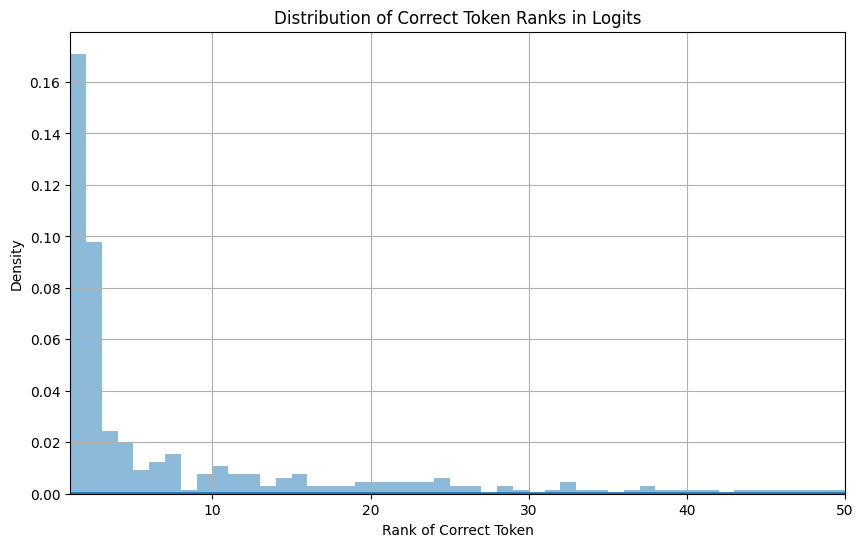

In [49]:
plot_correct_token_rank_distribution(output, fused_labels)

### After MLLM Fine-Tuning (410M Scale)

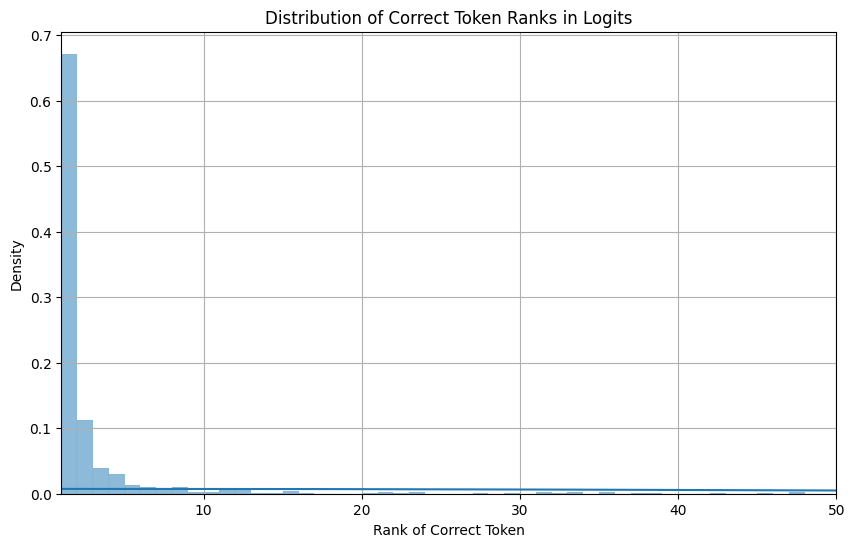

In [40]:
plot_correct_token_rank_distribution(output, fused_labels)

### After MLLM Fine-Tuning (1B Scale)

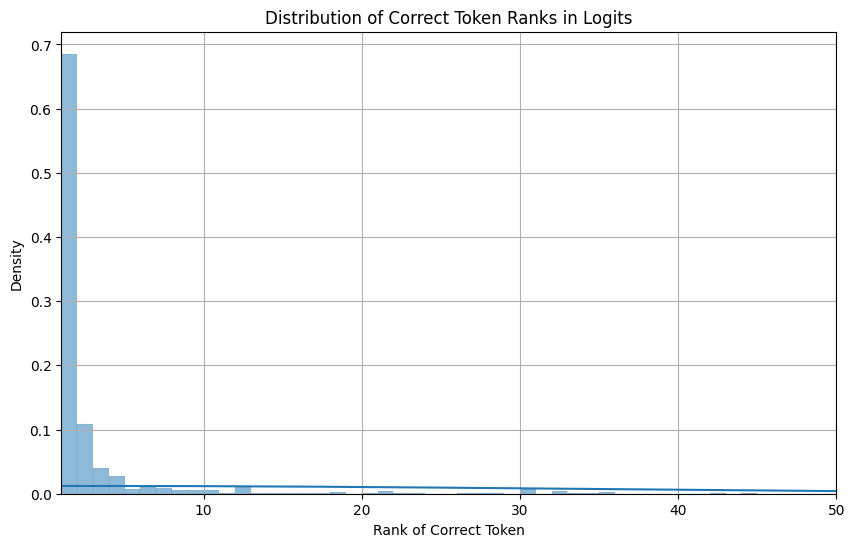

In [32]:
plot_correct_token_rank_distribution(output, fused_labels)

### After Alignment (1B Scale)

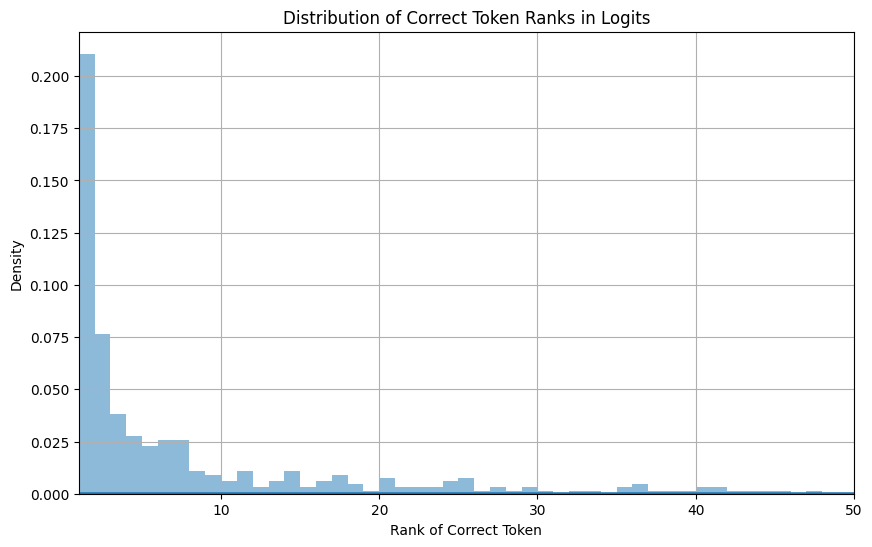

In [24]:
plot_correct_token_rank_distribution(output, fused_labels)

In [14]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
dtype = torch.float32
shift_logits = output.logits[:, :-1, :].contiguous().to(dtype).to(device)  # Shape: [batch_size, seq_length-1, num_classes]
valid_targets = fused_labels[:, 1:].contiguous().to(dtype).to(device)     # Shape: [batch_size, seq_length-1]

num_classes = shift_logits.size(-1)
mask = (valid_targets != -100)  # Ignored positions are marked with -100